# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [2]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning libraries
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp
from sklearn.svm import SVR

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
from mltools import regression_tools as RT
import warnings
from sklearn.svm import SVC

---
## 1. Read the dataset

In [3]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285
...             ...
2023-06-01  2688842
2023-07-01  2677874
2023-08-01  2702700
2023-09-01  2722468
2023-10-01  2759404

[274 rows x 1 columns]

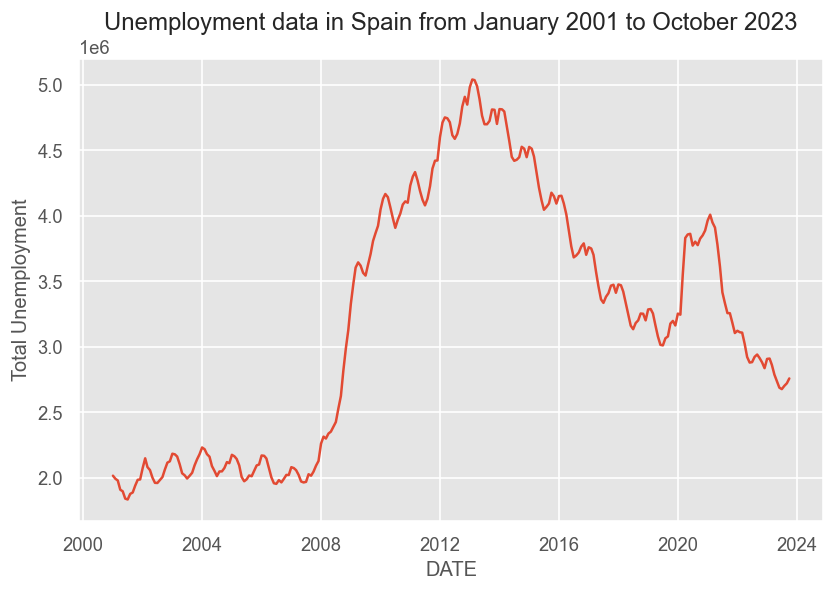

In [4]:
# Plotting a time series
fig, ax = plt.subplots()

ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2023', xlabel='DATE', ylabel='Total Unemployment')


plt.show()

In [5]:
y = df
prop_train=0.88

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(prop_train*y.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y.iloc[round(prop_train*y.shape[0])+1:round(y.shape[0])]

y_train.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción aproximada de 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 88/12 (para que el test no sea prácticamente del COVID, pero haya algún comportamiento raro en el test para observar diferencias entre modelos) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

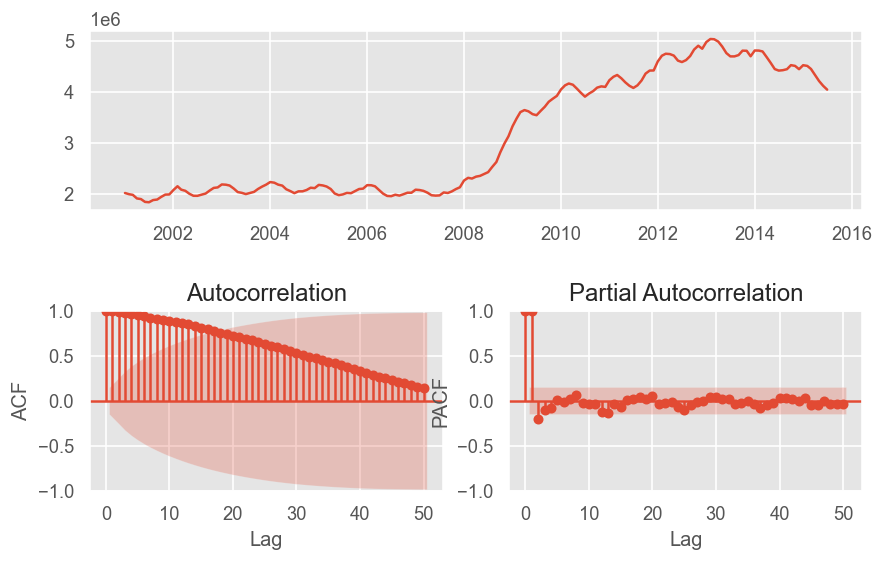

In [6]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

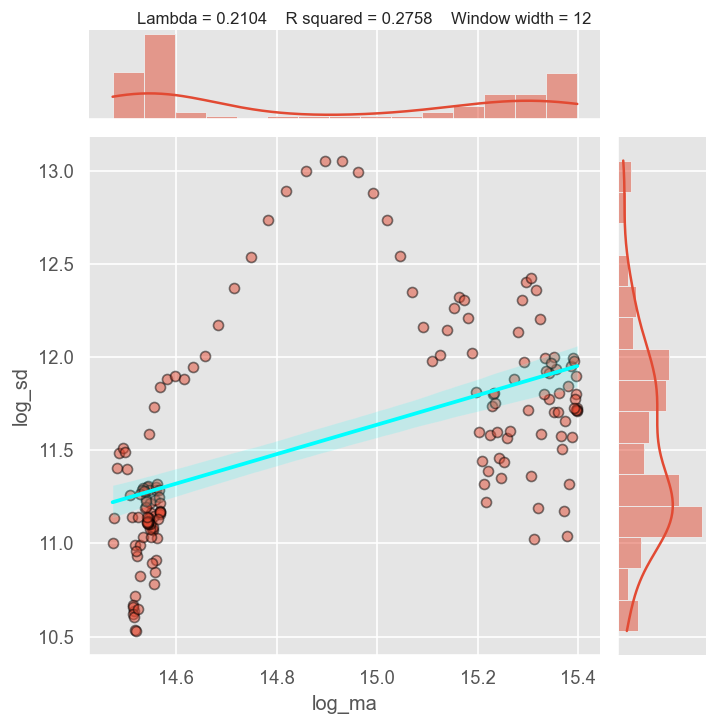

In [7]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

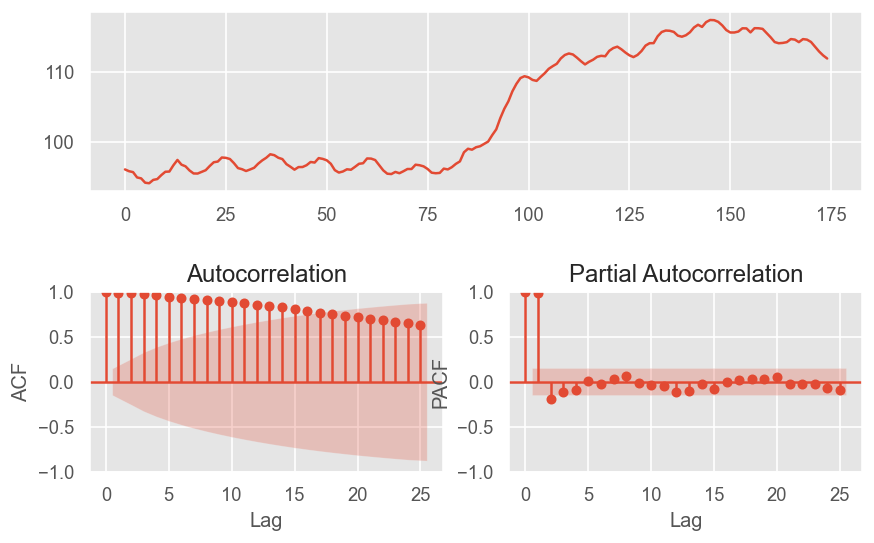

In [8]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

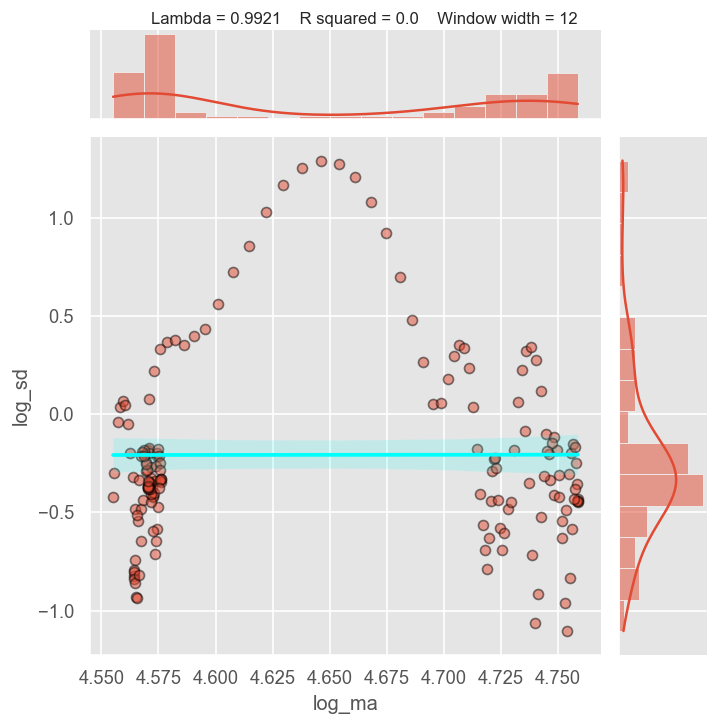

0.9921306069971021

In [9]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [361]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.391117
p-value: 0.586527
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


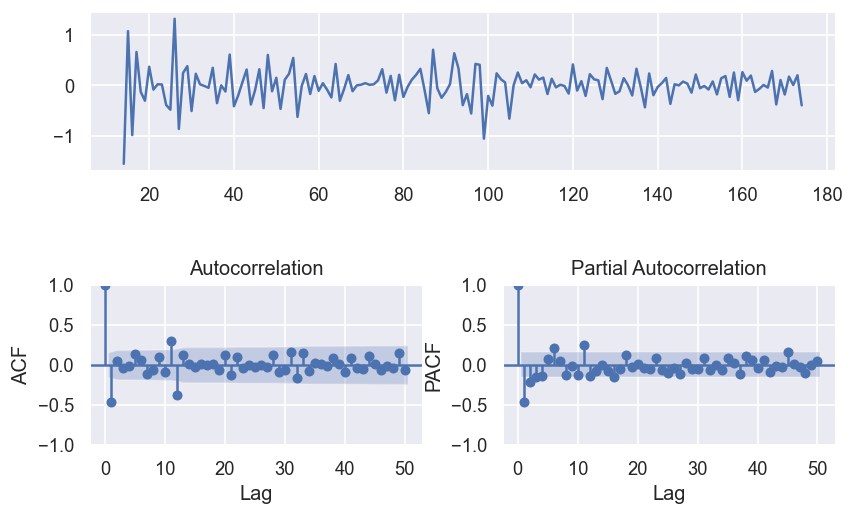

In [362]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

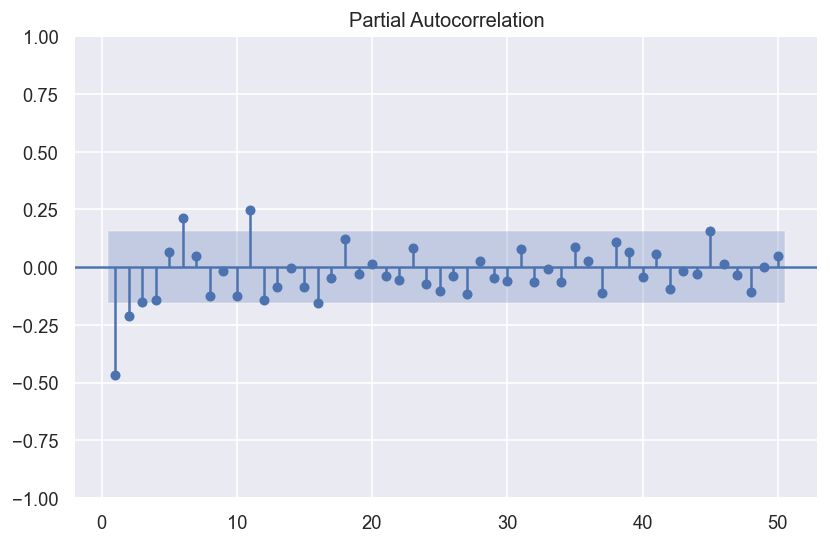

<Figure size 960x600 with 0 Axes>

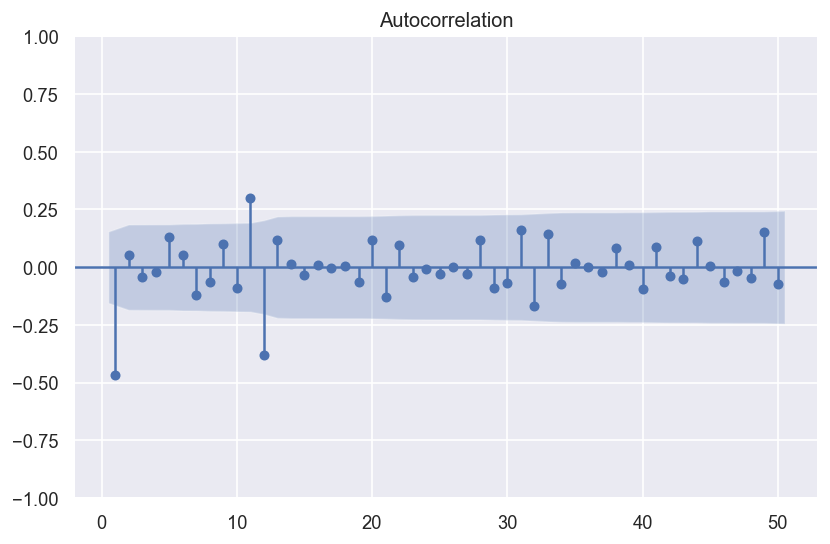

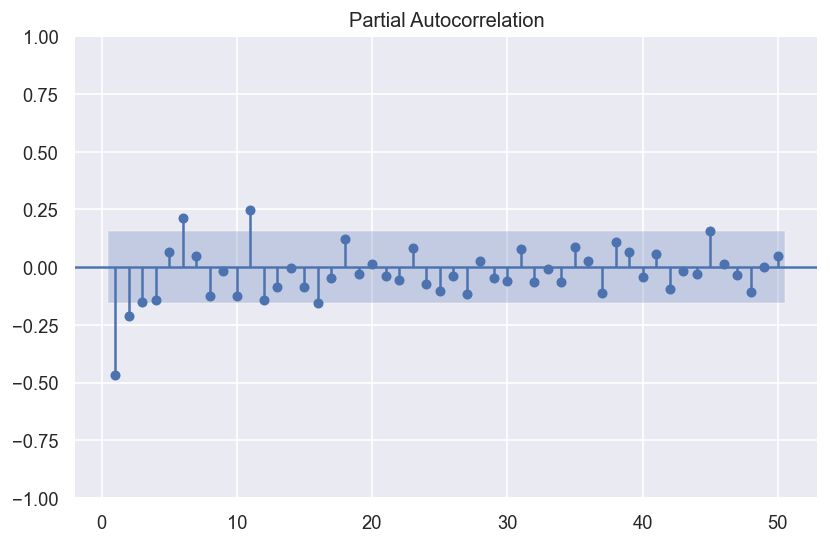

In [363]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [364]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96781D-02    |proj g|=  3.02762D-01

At iterate    5    f=  2.23011D-02    |proj g|=  1.45201D-02

At iterate   10    f=  2.16961D-02    |proj g|=  6.89094D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     22      1     0     0   4.666D-04   2.170D-02
  F =   2.1695984602812586E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  175
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  -3.797
Date:                            Fri, 01 Dec 2023   AIC                             13.594
Time:                                    12:20:46   BIC    

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  31.821279   0.163249


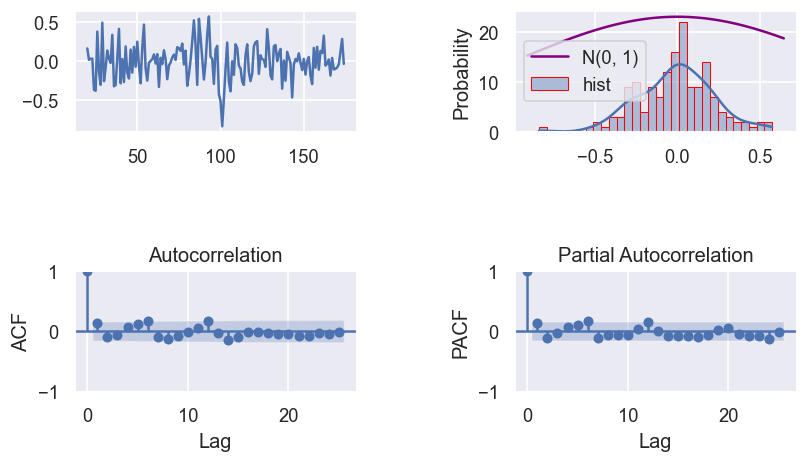

In [365]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [366]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56040D-02    |proj g|=  2.14200D-01

At iterate    5    f= -2.75915D-03    |proj g|=  1.88882D-02

At iterate   10    f= -4.14071D-03    |proj g|=  1.96672D-03

At iterate   15    f= -4.14326D-03    |proj g|=  1.97698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     23      1     0     0   1.048D-04  -4.143D-03
  F =  -4.1432649853255909E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.328068   0.828151


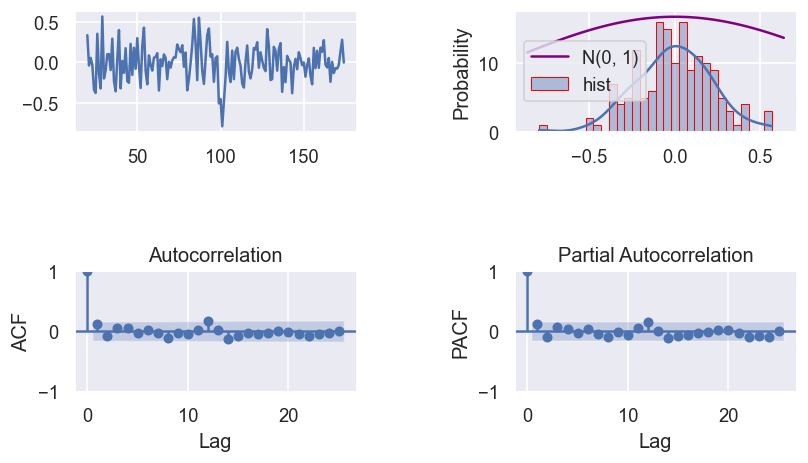

In [367]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

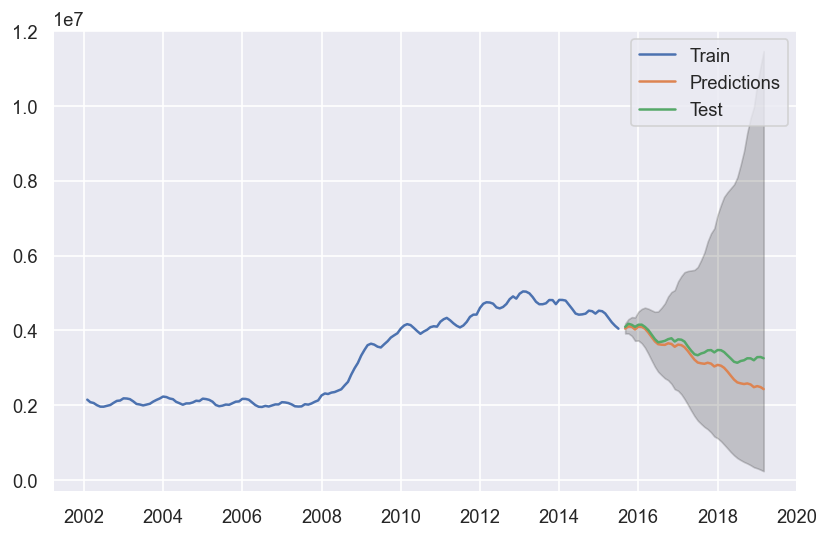

In [368]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

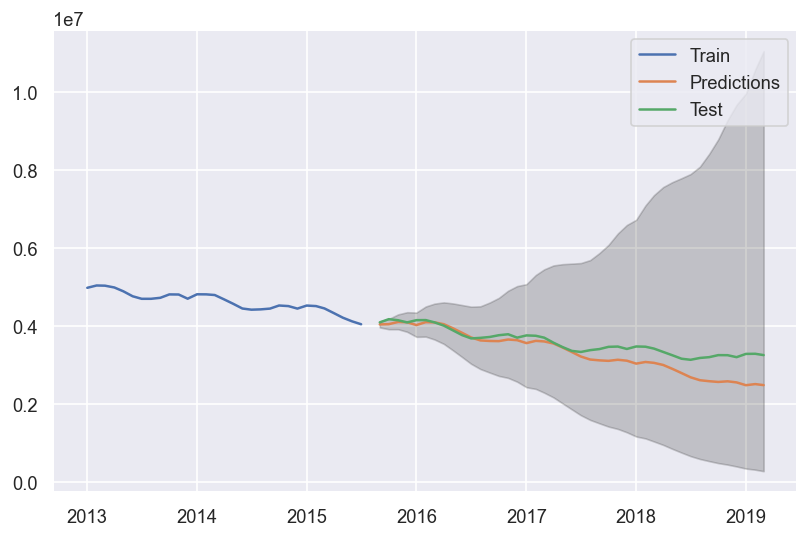

In [369]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [370]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 266711.98550756724
Test RMSE SARIMA 1 d = 2: 360965.2032924141


In [371]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66354D-02    |proj g|=  3.19505D-01


 This problem is unconstrained.



At iterate    5    f=  1.03942D-02    |proj g|=  2.64534D-02

At iterate   10    f=  7.04179D-03    |proj g|=  1.92878D-02

At iterate   15    f=  5.55684D-03    |proj g|=  9.19188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   5.786D-04   5.557D-03
  F =   5.5565166031774993E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test MAE SARIMA 1 d = 1: 210196.1379714429
Test RMSE SARIMA 1 d = 1: 240055.36278097206


In [372]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 235002.11395245843
Test RMSE SARIMA 2: 320186.27863015974


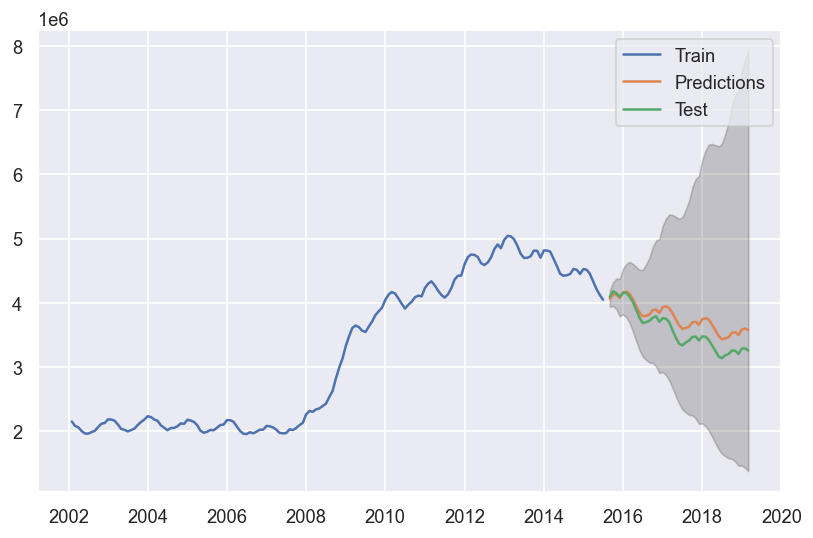

In [373]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit_aux.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

A pesar de lo esperado, el mejor modelo es `sarima_fit_aux` en términos de métricas y simplicidad (con unas predicciones similares), por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

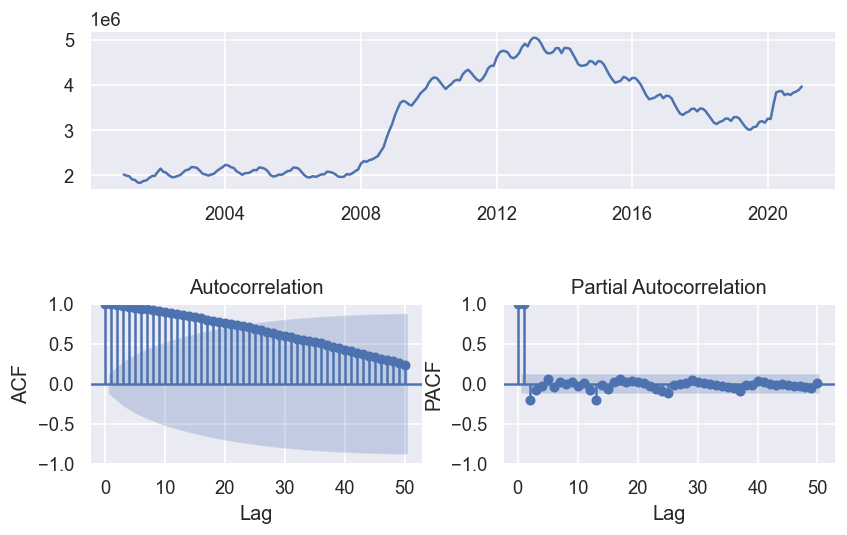

In [374]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

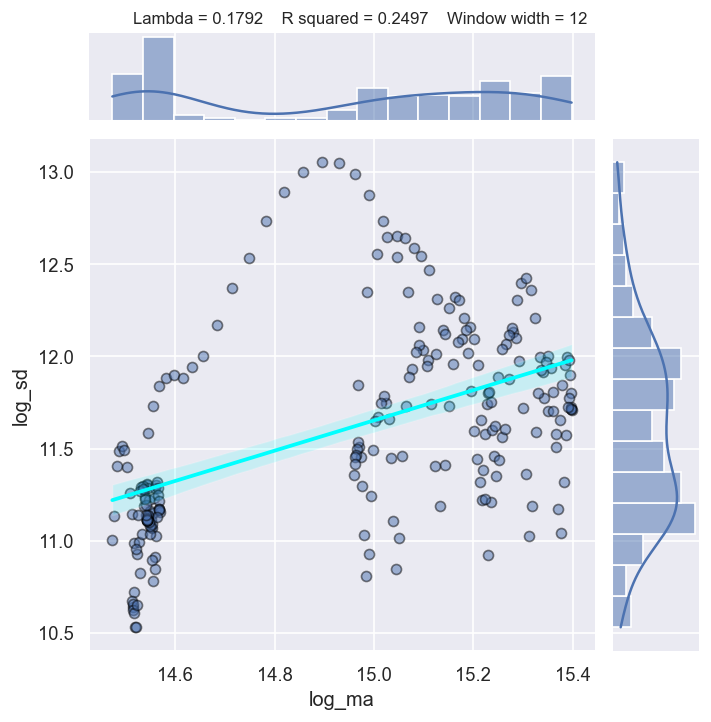

In [375]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

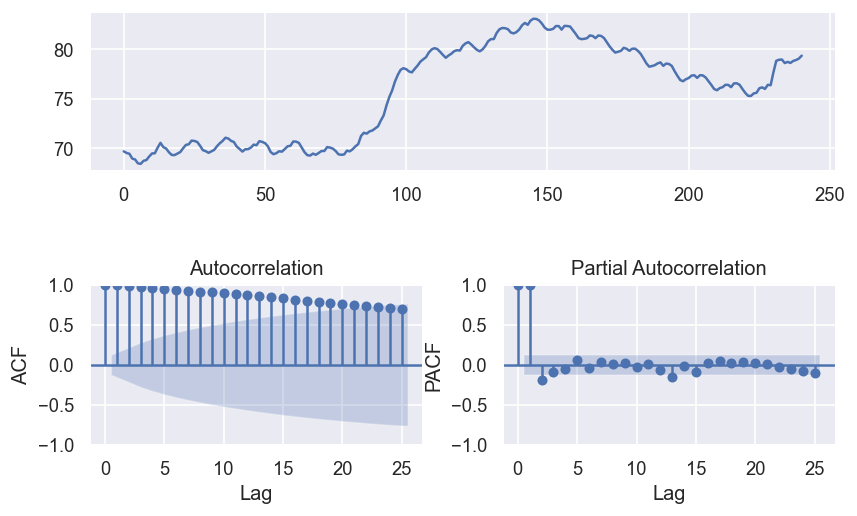

In [376]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

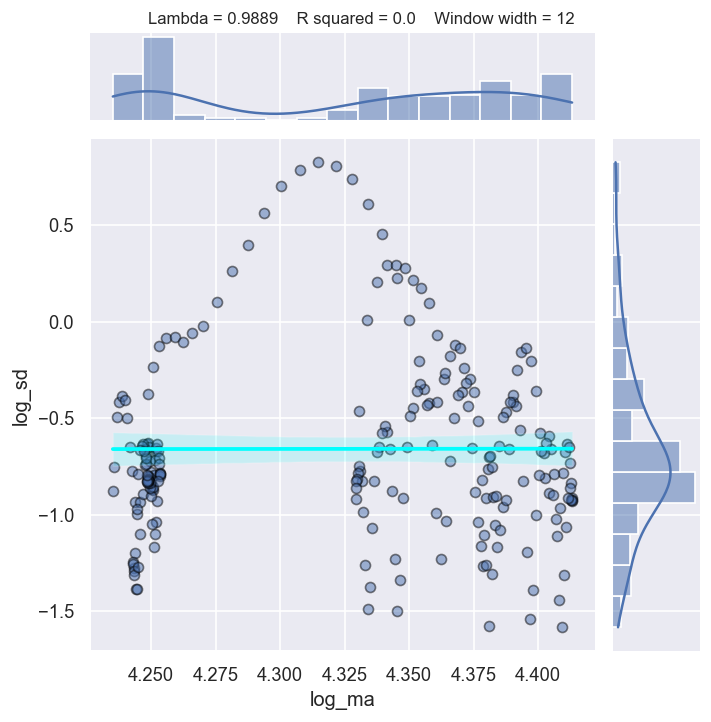

0.9889334090138504

In [377]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [378]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.593455
p-value: 0.486880
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


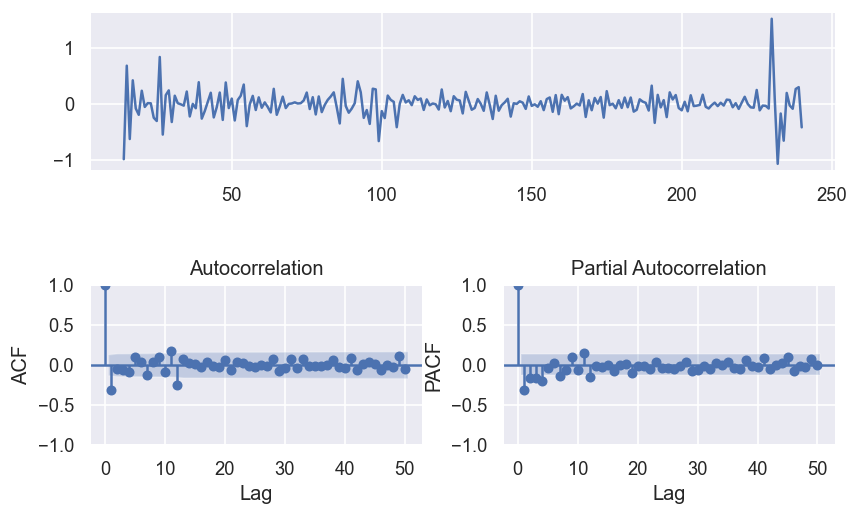

In [379]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [380]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93995D-01    |proj g|=  4.34538D-01

At iterate    5    f= -2.13073D-01    |proj g|=  1.56355D-01

At iterate   10    f= -2.19584D-01    |proj g|=  4.35490D-01

At iterate   15    f= -2.25959D-01    |proj g|=  7.67286D-03

At iterate   20    f= -2.26892D-01    |proj g|=  2.44331D-02

At iterate   25    f= -2.27217D-01    |proj g|=  1.64591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
25  9.946319   0.996794


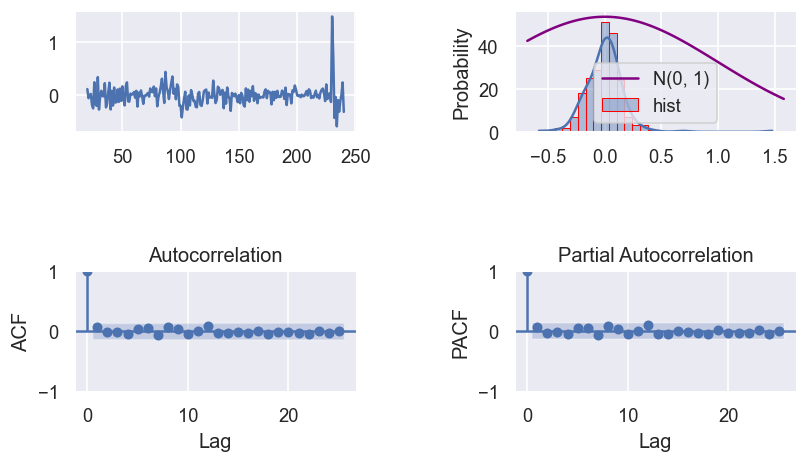

In [381]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

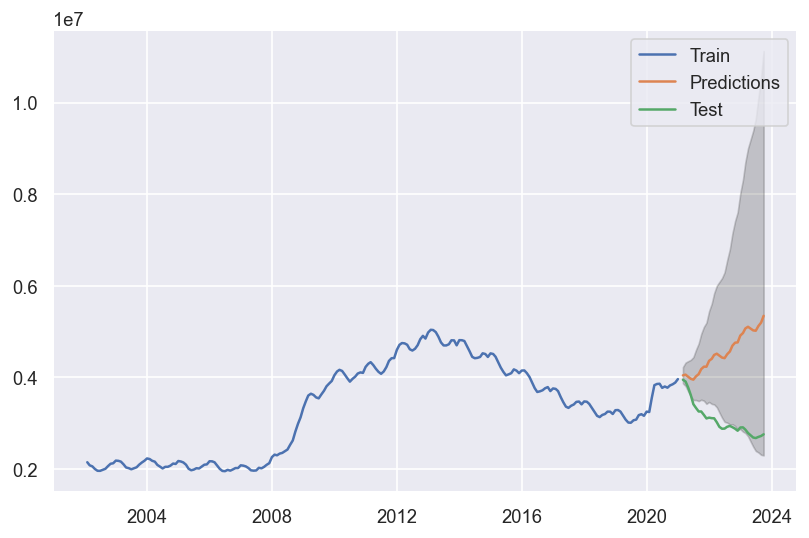

In [382]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [383]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 1497247.6631776781
Test RMSE SARIMA 1 d = 2: 1663251.3686611715


In [384]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88543D-01    |proj g|=  1.44166D-01


 This problem is unconstrained.



At iterate    5    f= -2.32282D-01    |proj g|=  2.27931D-02

At iterate   10    f= -2.33557D-01    |proj g|=  3.13827D-03

At iterate   15    f= -2.33641D-01    |proj g|=  1.83527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   5.812D-04  -2.336D-01
  F = -0.23364088519840137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  15.480245    0.92943


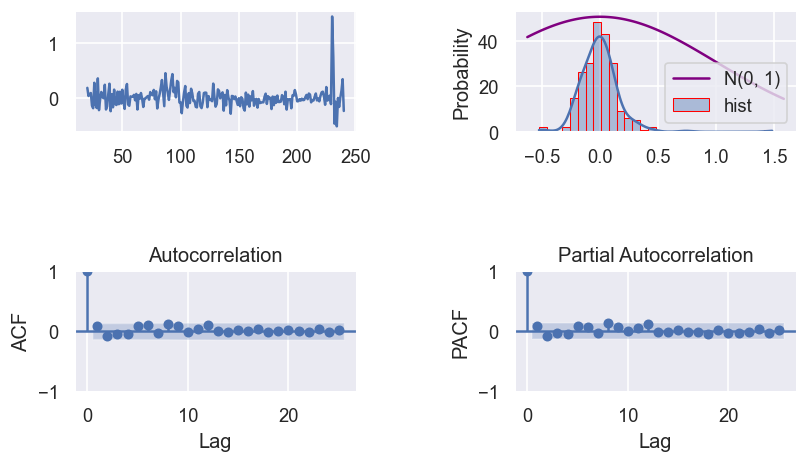

In [385]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

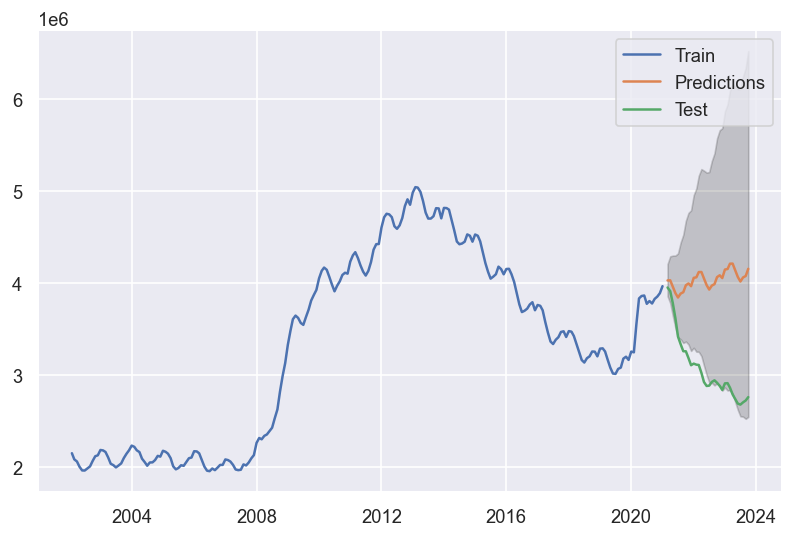

In [386]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [387]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 1: 969152.2836484313
Test RMSE SARIMA 1 d = 1: 1046467.7978979676


Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores (aún así, su intervalo de confianza es menor, lo cual es bueno). De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **SARIMAX**

Se procede a incluir una variable de intervención que palie el efecto provocado por el COVID en nuestra serie temporal.

Esta variable simplemente será una binaria que tome el valor 1 para observaciones en fechas dentro del periodo en que el COVID tuvo un efecto en la serie, y 0 para las fechas fuera de dicho periodo.

In [11]:
#df['COVID_Desc']=0
#df['COVID_Asc']=0
df['COVID']=0
#df['CRISIS']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-03-01') #Parece que aquí termina su influencia ascendente en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2023-09-01') #Parece que aquí termina su influencia descendente en nuestra serie
periodo_zapatero_inicio= pd.to_datetime('2007-08-01')
periodo_zapatero_fin=pd.to_datetime('2013-01-01')


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
#df.loc[periodo_zapatero_inicio:periodo_zapatero_fin, 'CRISIS'] =1
#df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID_Asc'] =1

prop_train=0.88#Proporción de datos usada para entrenamiento


print(df['COVID'].value_counts())
 

COVID
0    261
1     13
Name: count, dtype: int64


In [12]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

X_train2

COVID
DATE             
2001-01-01      0
2001-02-01      0
2001-03-01      0
2001-04-01      0
2001-05-01      0
...           ...
2020-09-01      1
2020-10-01      1
2020-11-01      1
2020-12-01      1
2021-01-01      1

[241 rows x 1 columns]

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

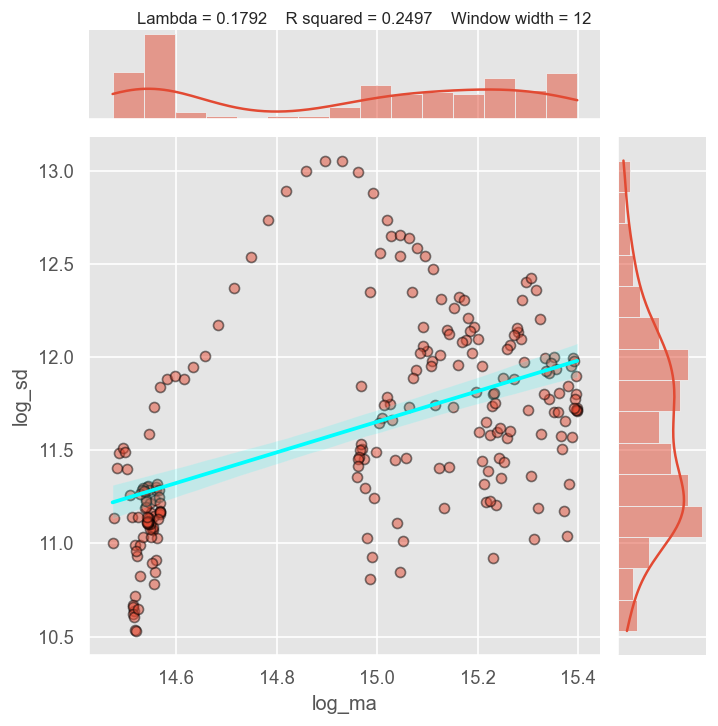

In [13]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

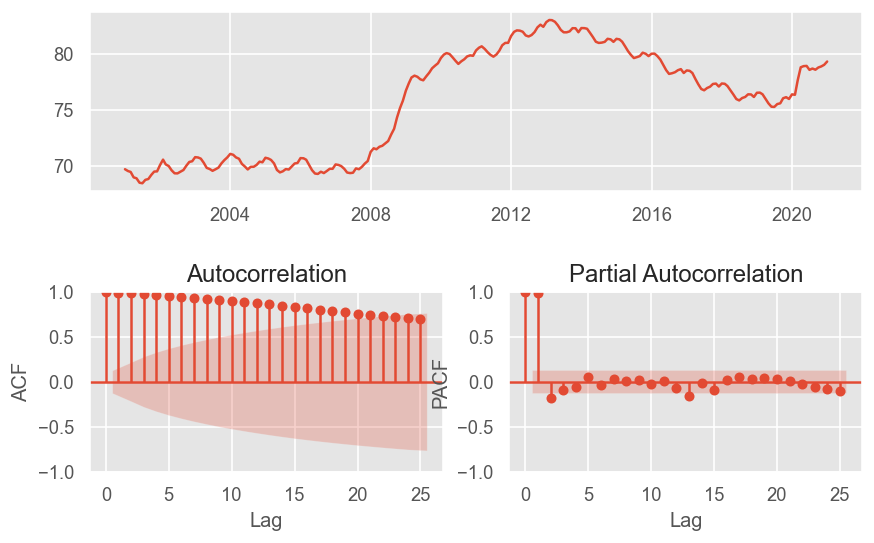

In [14]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [15]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  73.213
Date:                            Fri, 01 Dec 2023   AIC                           -136.425
Time:                                    17:18:12   BIC                           -119.278
Sample:                                01-01-2001   HQIC                          -129.507
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          0.9796      0.054     18.073      0.000       0.873       1.086
ar.L1          0.8418      0.042   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  35.530035   0.939159


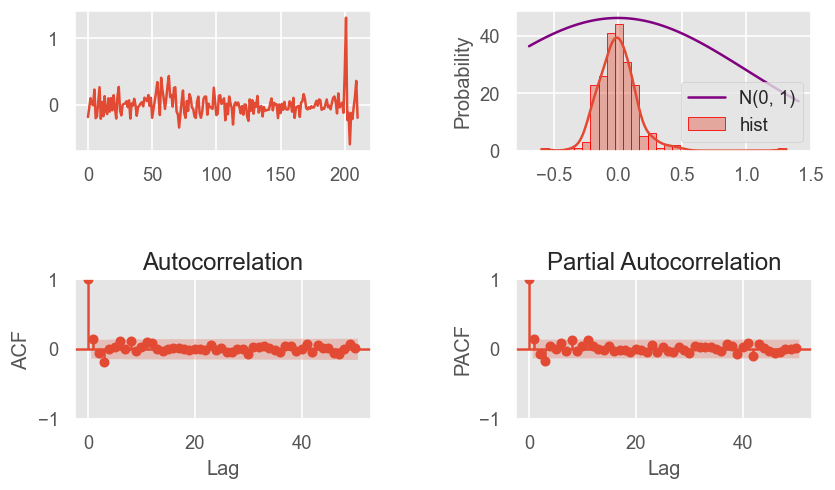

In [16]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)
 

Se ha iniciando probando el modelo óptimo obtenido en el SARIMA(1,2,1)x(0,1,1,12) obteniendo resultados muy malos para los residuos, tras ello se han seguido probando modelos incluyendo diferenciación tanto regular como estacional en los modelos, siempre observando correlaciones parciales muy altas entre los residuos de la serie y sus retardos estacionales(E(12),E(24),E(36,...)).Cambiar los parámetros del sarimax en el código para ver este fenómeno.

Por último, se decidió eliminar la diferenciación estacional para ver si de esta manera se conseguía eliminar este efecto, y se consiguió, llegando al modelo óptimo mostrado arriba, en que prácticamenete con un 100% de confianza se afirma que los residuos del modelo son ruido blanco(Ver p-valor del test de Ljung-Box).

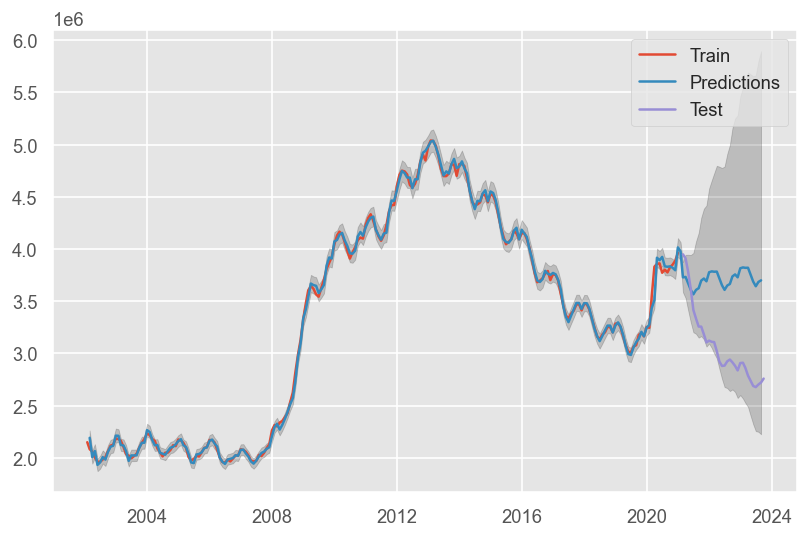

In [17]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [19]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX DUMMY:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMAX DUMMY:',math.sqrt(mean_squared_error(y_test2, yhat)))
 

Test MAE SARIMAX DUMMY: 668470.561997281
Test RMSE SARIMAX DUMMY: 732754.6863232849


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

# SARIMAX DUMMY 1/-1

In [50]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-03-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2023-10-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =-1


df['COVID'].astype('category')

df['COVID'].value_counts()#únicamente el COVID afecta a un 11% de nuestras observaciones

COVID
 0    230
-1     32
 1     12
Name: count, dtype: int64

In [51]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

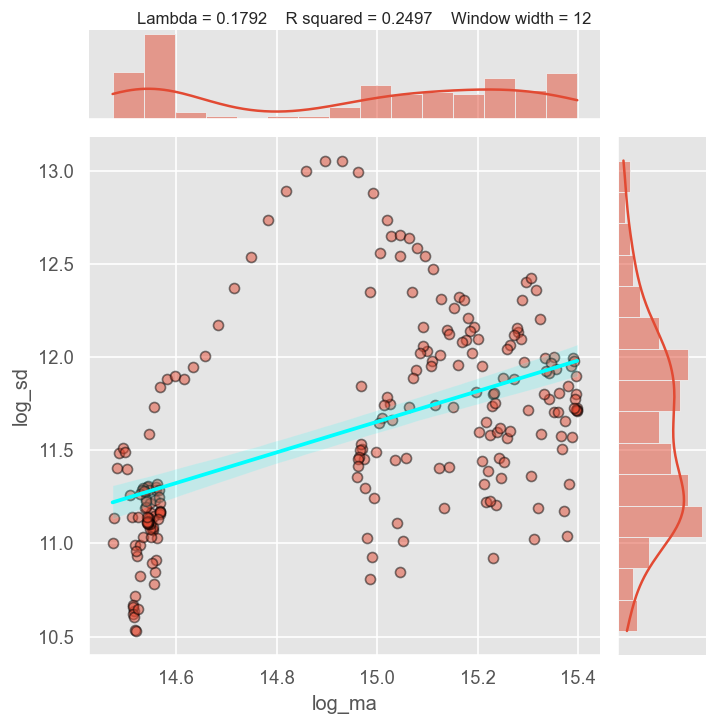

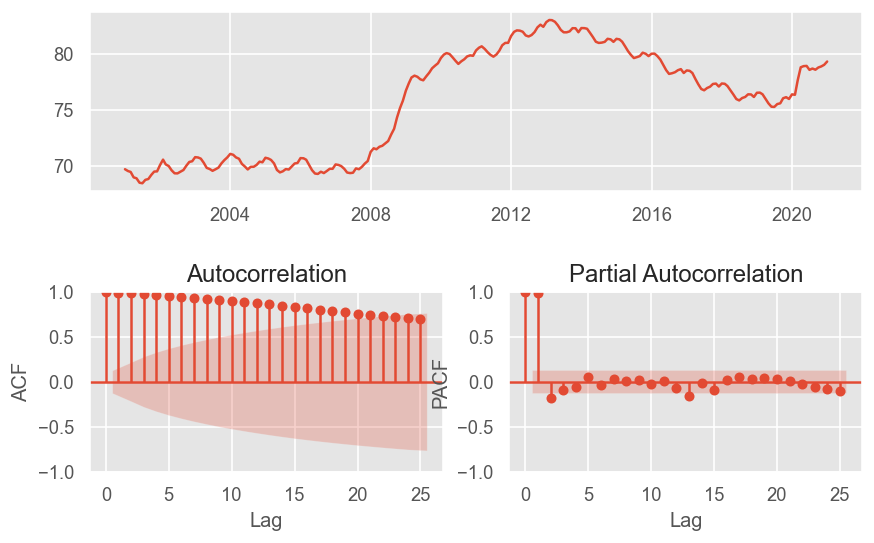

In [23]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)


# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)



In [24]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  73.213
Date:                            Fri, 01 Dec 2023   AIC                           -136.425
Time:                                    17:18:47   BIC                           -119.278
Sample:                                01-01-2001   HQIC                          -129.507
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          0.9796      0.054     18.073      0.000       0.873       1.086
ar.L1          0.8418      0.042   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  35.530035   0.939159


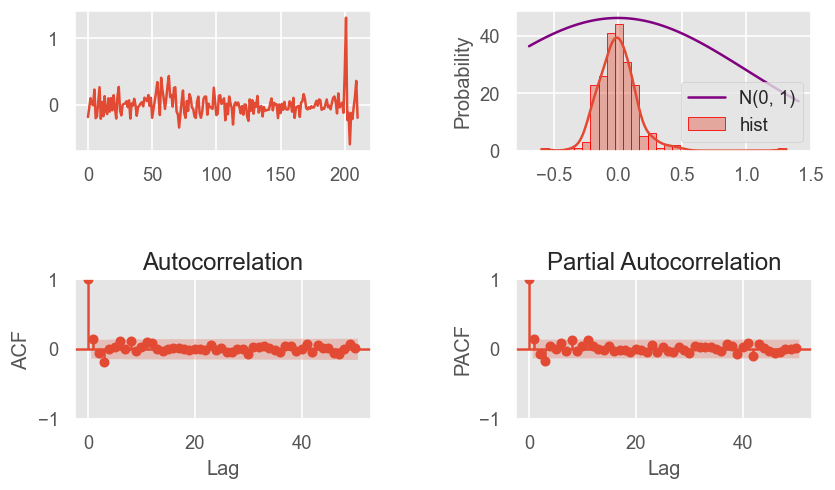

In [25]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)

In [64]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

ValueError: Provided exogenous values are not of the appropriate shape. Required (32, 1), got (33, 1).

In [27]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX DUMMY -1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMAX DUMMY -1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMAX DUMMY -1: 498519.63307203964
Test RMSE SARIMAX DUMMY -1: 540580.9062243092


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

In [81]:
#November 2023 prediction


start=X_train2.shape[0]+1
end=X.shape[0]
noviembre_2023 = {'COVID': -1.0}
diciembre_2023 = {'COVID': -1.0}

# Añadir la nueva observación usando loc
X_test2.loc[pd.to_datetime('2023-11-01')] = noviembre_2023
X_test2.loc[pd.to_datetime('2023-12-01')] = diciembre_2023#No me deja sin meter la de diciembre tb.

 
pred = res_sarimax.get_prediction(start=start,
                                end=end, 
                                exog=X_test2[INPUTS_SARMAX],
                                dynamic=False)

sp.special.inv_boxcox(pred.predicted_mean['2023-11-01'], lmbda)

C:\Users\LOLI\AppData\Local\Temp\ipykernel_10904\3000100367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test2.loc[pd.to_datetime('2023-11-01')] = noviembre_2023
C:\Users\LOLI\AppData\Local\Temp\ipykernel_10904\3000100367.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test2.loc[pd.to_datetime('2023-12-01')] = diciembre_2023#No me deja sin meter la de diciembre tb.


71.4936737381011

# SARIMAX TIME VARYING COEFS.

In [92]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-03-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2021-08-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =np.linspace(1,0,6)

prop_train=0.88#Proporción de datos usada para entrenamiento o test

df['COVID'].value_counts() 

C:\Users\LOLI\AppData\Local\Temp\ipykernel_10904\1923318743.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.  0.8 0.6 0.4 0.2 0. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =np.linspace(1,0,6)


COVID
0.0    257
1.0     13
0.8      1
0.6      1
0.4      1
0.2      1
Name: count, dtype: int64

In [93]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

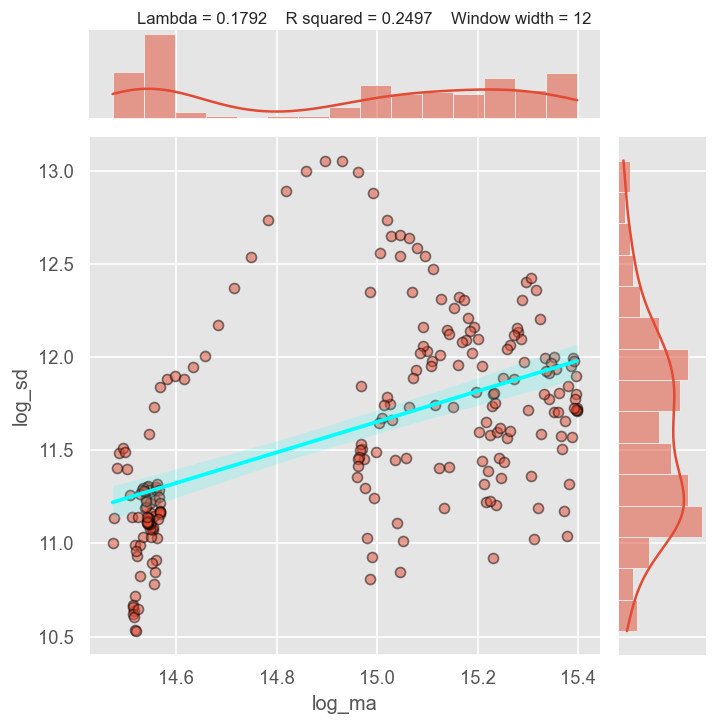

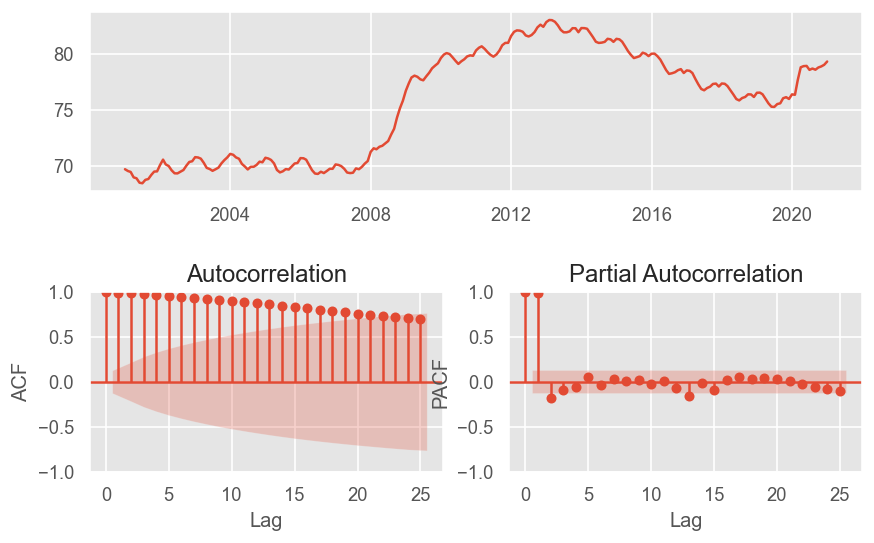

In [94]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)


# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [95]:
#time_varying_regression
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=True,
                            mle_regression=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  99.073
Date:                            Fri, 01 Dec 2023   AIC                           -188.147
Time:                                    17:46:33   BIC                           -171.022
Sample:                                01-01-2001   HQIC                          -181.237
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7688      0.040     19.125      0.000       0.690       0.848
ma.L1          0.0970      0.075   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  63.327612   0.097612


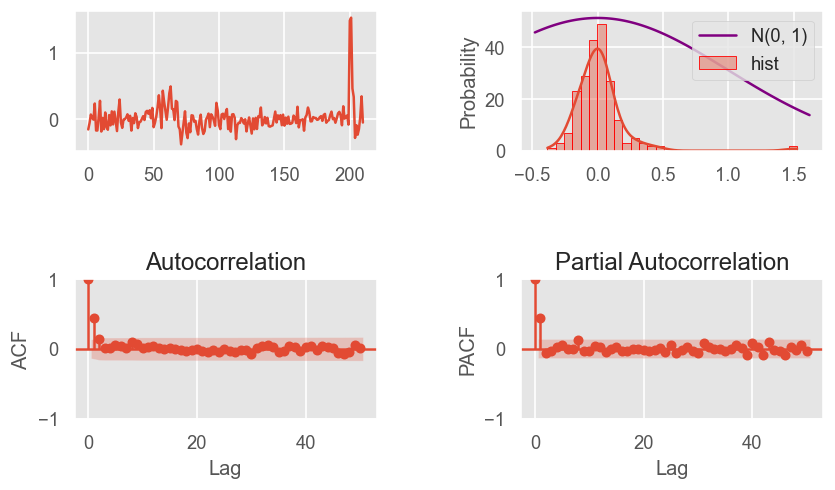

In [96]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)

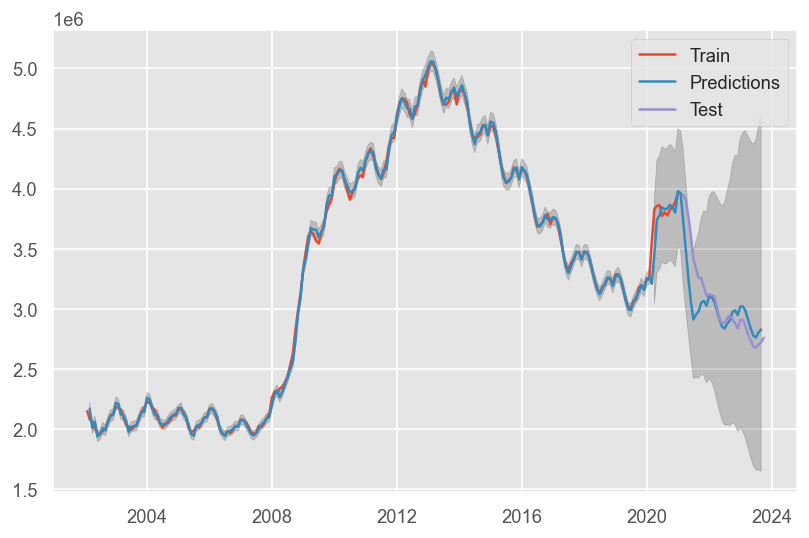

In [97]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [98]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX TVC:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA TVC:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMAX TVC: 152333.2262838794
Test RMSE SARIMA TVC: 215177.35196076898


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

In [100]:
#November 2023 prediction


start=X_train2.shape[0]+1
end=X.shape[0]
noviembre_2023 = {'COVID': 0.0}
diciembre_2023 = {'COVID': 0.0}

# Añadir la nueva observación usando loc
X_test2.loc[pd.to_datetime('2023-11-01')] = noviembre_2023
X_test2.loc[pd.to_datetime('2023-12-01')] = diciembre_2023#No me deja sin meter la de diciembre tb.

 
pred = res_sarimax.get_prediction(start=start,
                                end=end, 
                                exog=X_test2[INPUTS_SARMAX],
                                dynamic=False)

sp.special.inv_boxcox(pred.predicted_mean['2023-11-01'], lmbda)

C:\Users\LOLI\AppData\Local\Temp\ipykernel_10904\3939810309.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test2.loc[pd.to_datetime('2023-11-01')] = noviembre_2023
C:\Users\LOLI\AppData\Local\Temp\ipykernel_10904\3939810309.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test2.loc[pd.to_datetime('2023-12-01')] = diciembre_2023#No me deja sin meter la de diciembre tb.


2911898.328180908

# MLP

In [228]:
df['COVID'] = df.COVID.astype('category')


In [229]:
###Includb
dfT = df[['TOTAL','COVID']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
dfT['TOTAL_lag12'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12
DATE                                                          
2001-01-01  2017389     0         NaN         NaN          NaN
2001-02-01  1993273     0   2017389.0         NaN          NaN
2001-03-01  1981006     0   1993273.0   2017389.0          NaN
2001-04-01  1910453     0   1981006.0   1993273.0          NaN
2001-05-01  1898285     0   1910453.0   1981006.0          NaN

In [230]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12
DATE                                                          
2002-01-01  2075022     0   1988716.0   1985857.0    2017389.0
2002-02-01  2149907     0   2075022.0   1988716.0    1993273.0
2002-03-01  2083103     0   2149907.0   2075022.0    1981006.0
2002-04-01  2060069     0   2083103.0   2149907.0    1910453.0
2002-05-01  2002923     0   2060069.0   2083103.0    1898285.0

In [231]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag12','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag12 COVID
DATE                                                 
2002-01-01   1988716.0   1985857.0    2017389.0     0
2002-02-01   2075022.0   1988716.0    1993273.0     0
2002-03-01   2149907.0   2075022.0    1981006.0     0
2002-04-01   2083103.0   2149907.0    1910453.0     0
2002-05-01   2060069.0   2083103.0    1898285.0     0

In [232]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag12']
INPUTS_MLP_CAT = ['COVID'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.00001,0.0001,0.01,0.1,1], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(10,),(20,),(25,),(30,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train2[INPUTS_MLP], y_train2) # Search in grid
print("MLP Trained")

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

MLP Trained


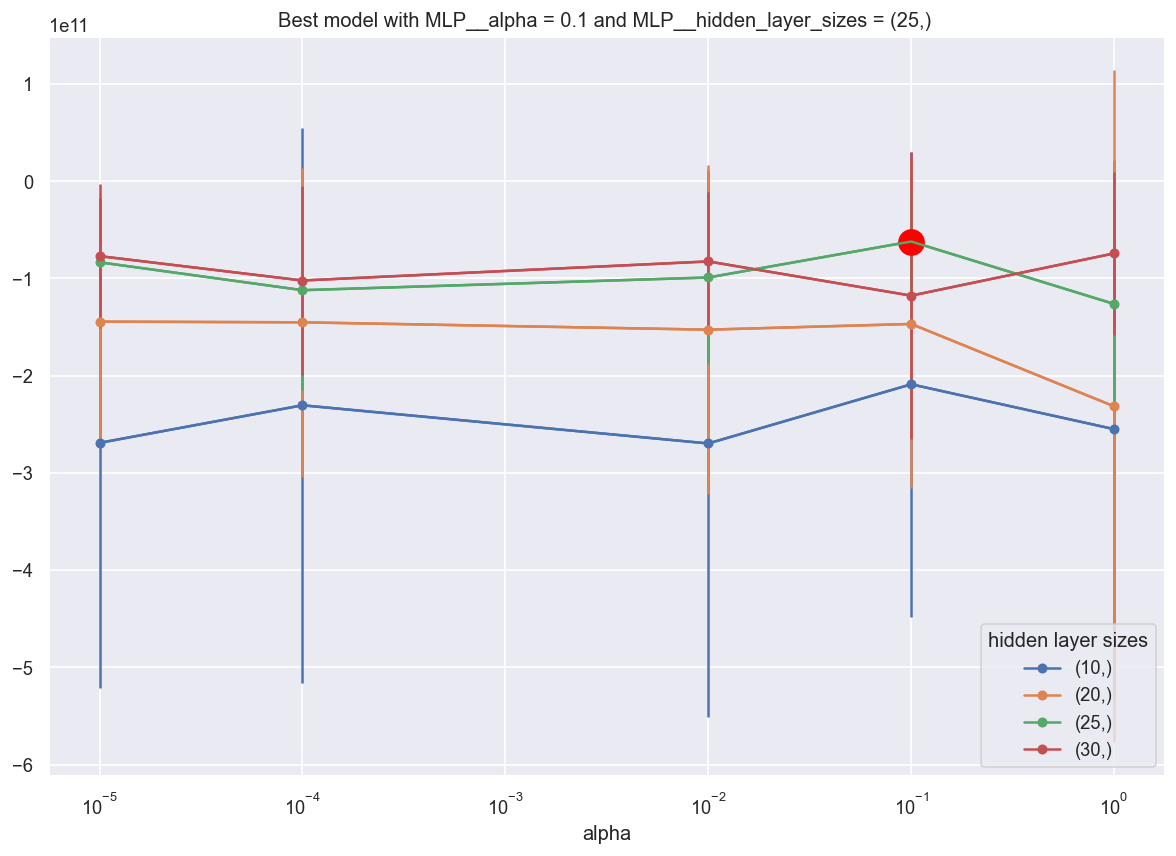

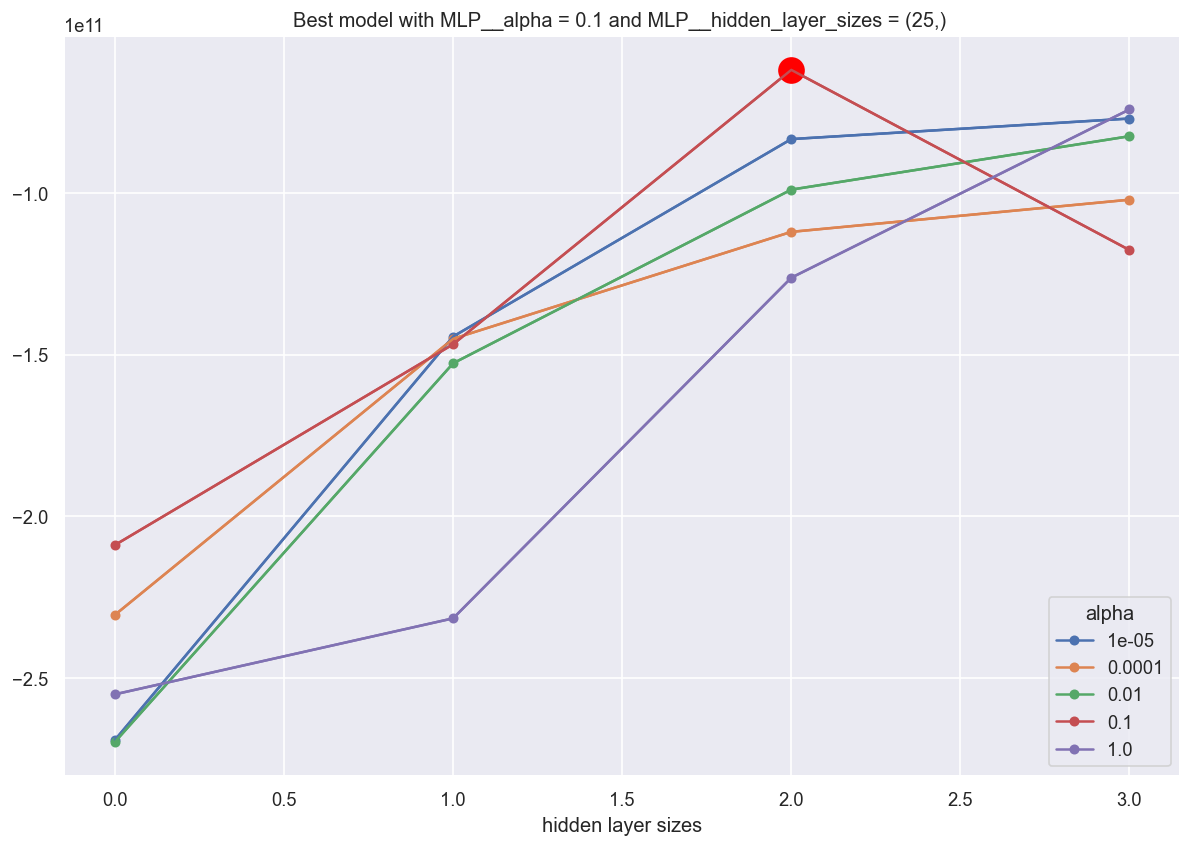

In [233]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [234]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train2) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)

#X = pd.DataFrame(X.toarray(), columns=coefnames)
y = pd.DataFrame(y_train2, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [4, 25, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                          mean           std  mean_squared
num__TOTAL_lag1   1.045333e+07  8.095964e+07  8.163171e+07
num__TOTAL_lag2   1.061421e+07  8.425999e+07  8.492590e+07
num__TOTAL_lag12  8.882456e+06  6.996647e+07  7.052805e+07
cat__COVID_1      4.275938e+05  9.806550e+06  9.815868e+06


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\neuralsens\partial_derivatives.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(sens_out["mean"][i], sens_out["std"][i]),
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


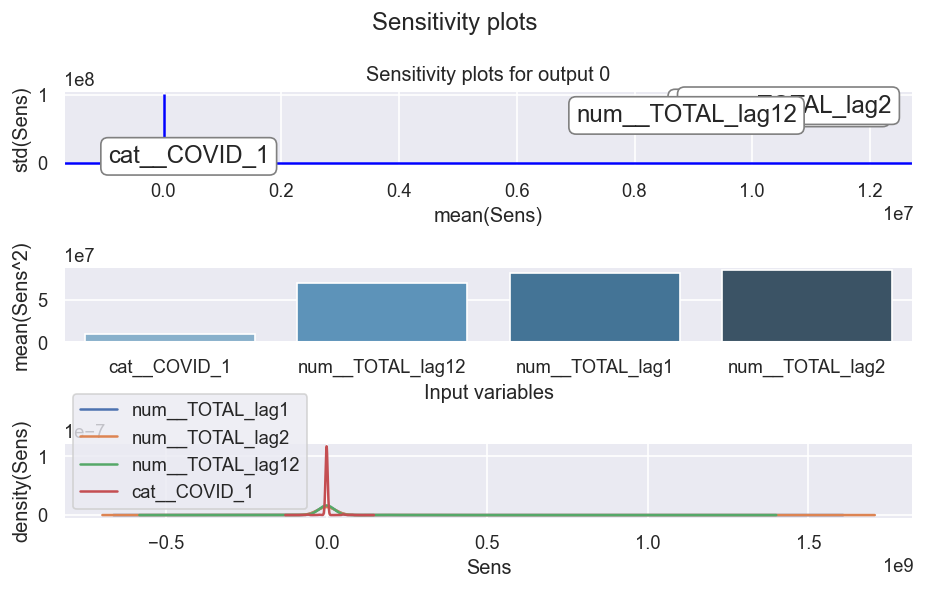

In [235]:
sensmlp.plot()

In [236]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train2)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test2)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))

#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 173069.75890070852
Test MAE: 460138.8560628546
Training RMSE: 218691.02954458672
Test RMSE: 482389.9793190481
Training R2: 0.9521023319421802
Test R2: -2.2469516620602574


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

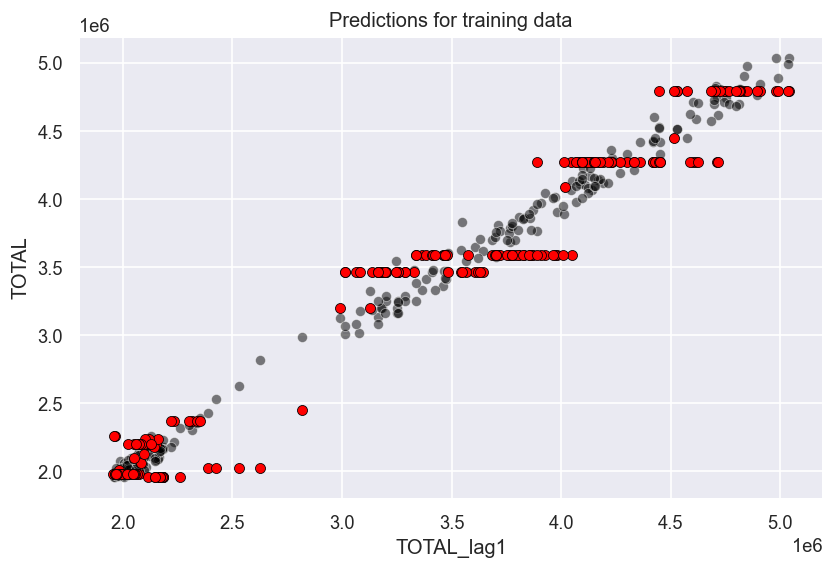

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

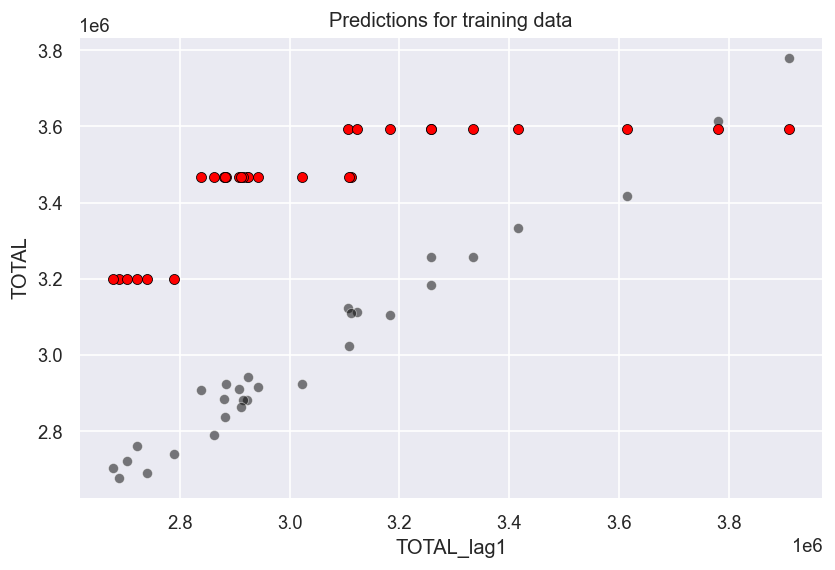

In [237]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


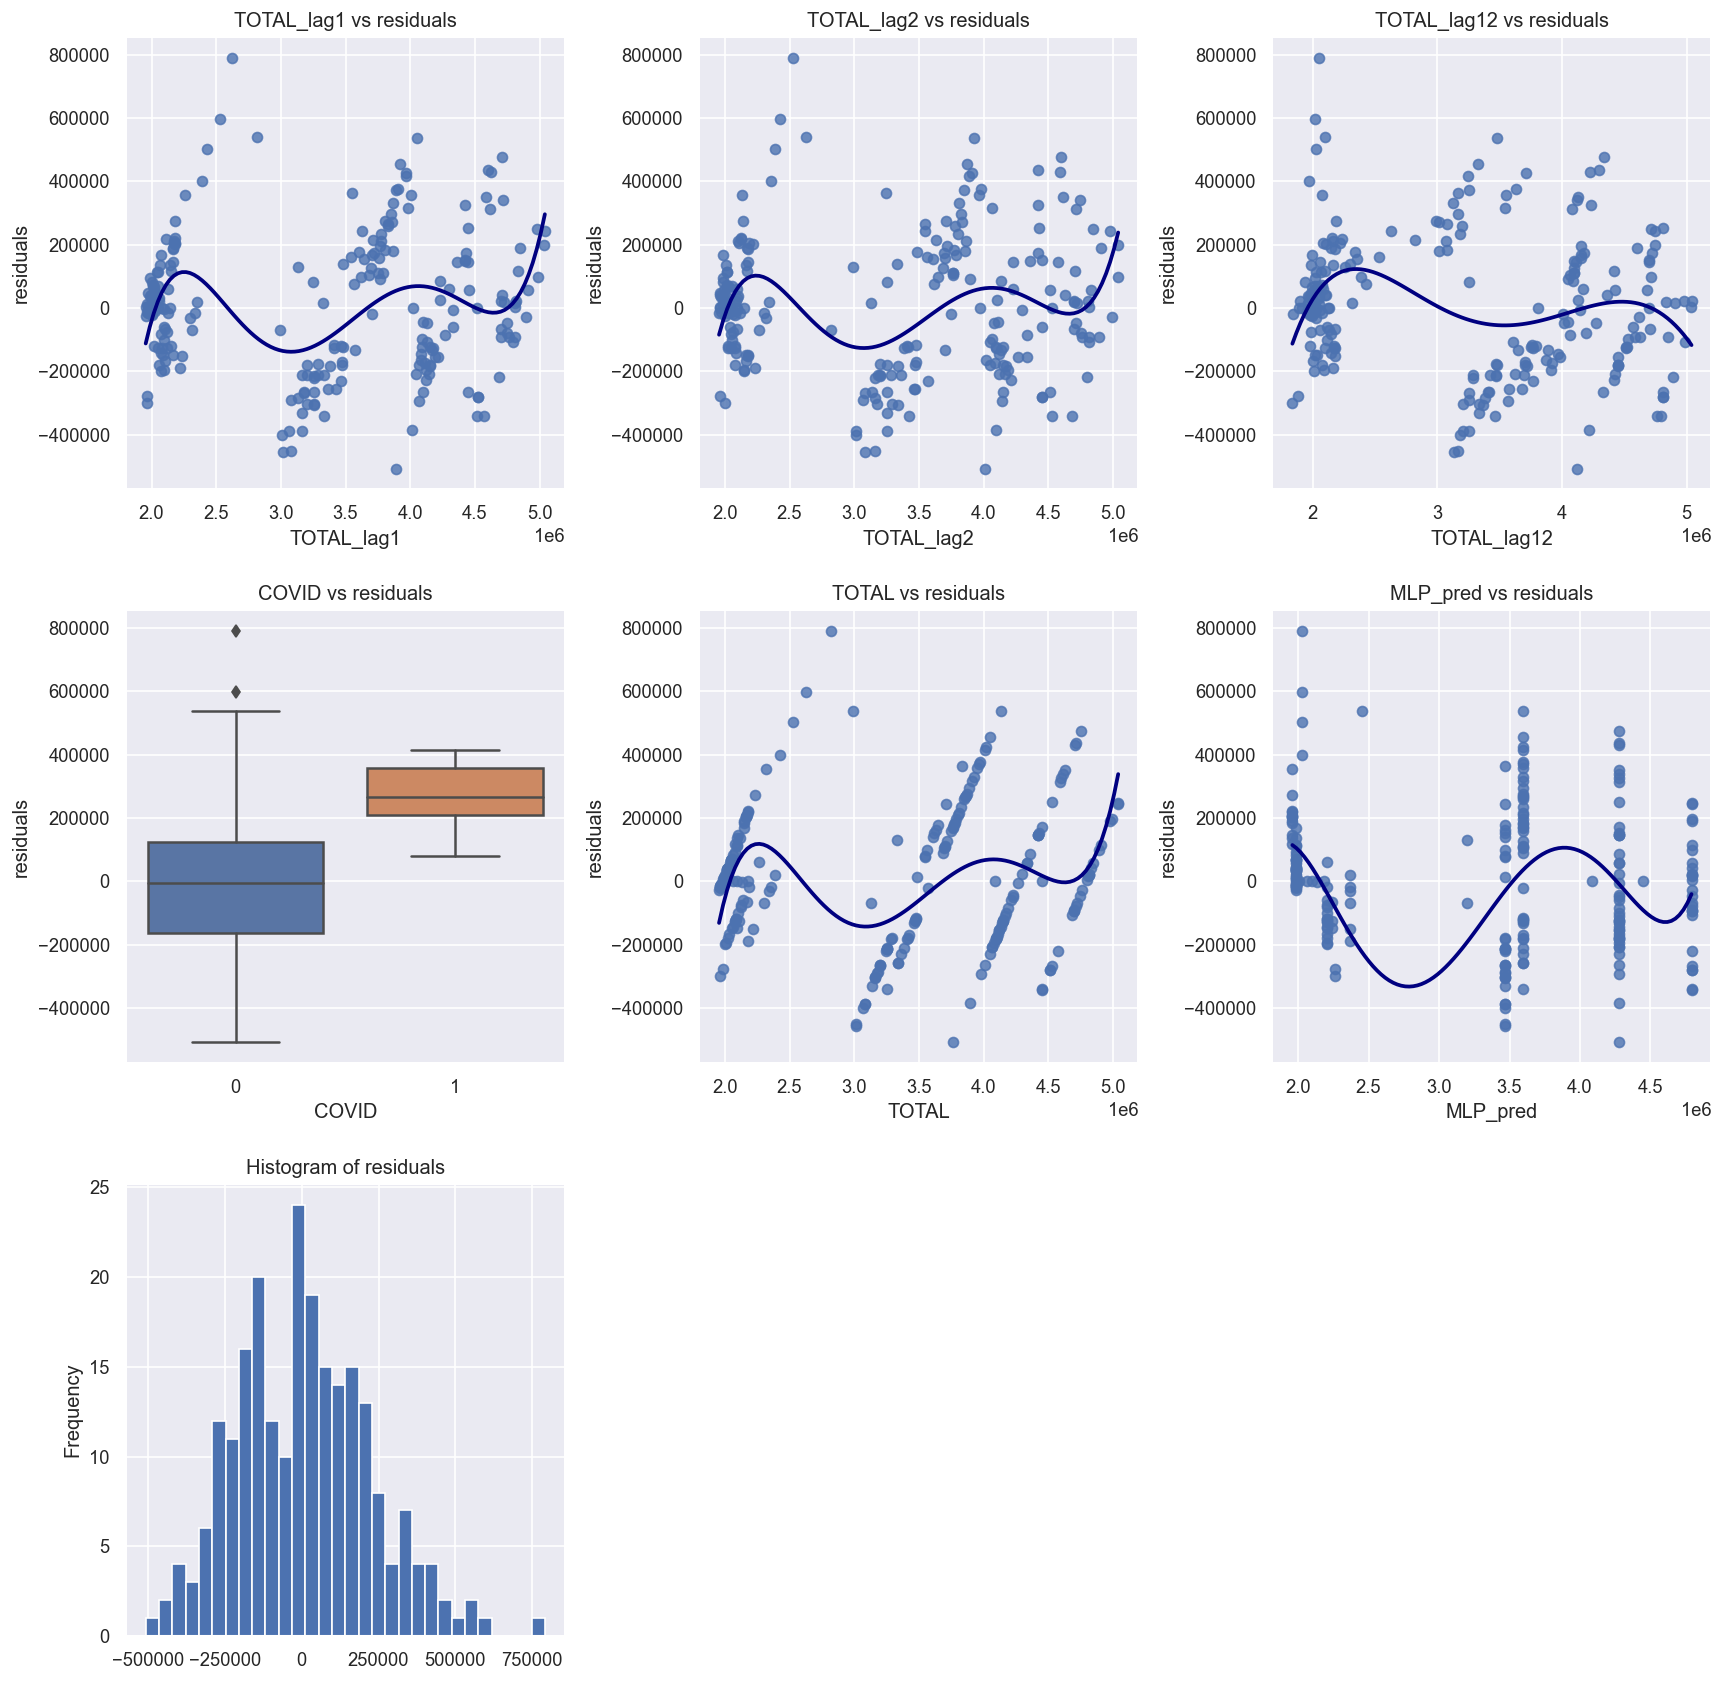

In [238]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

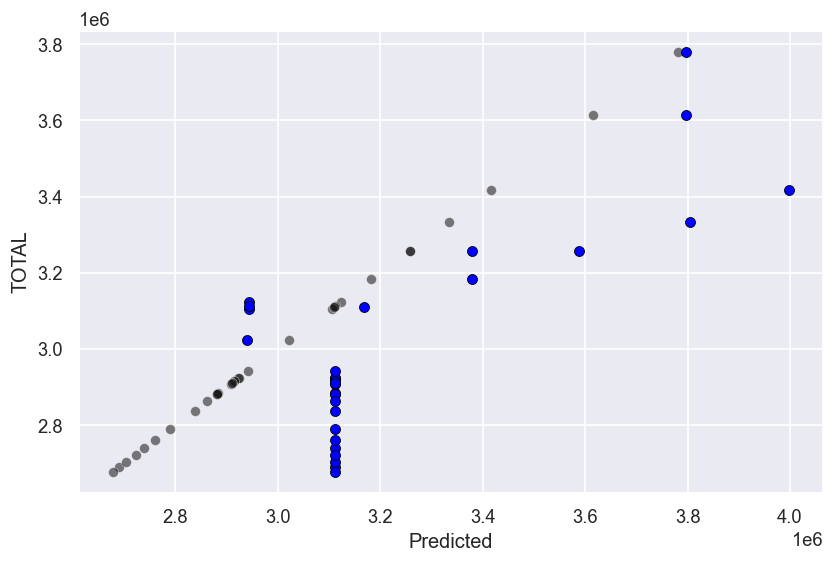

In [421]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

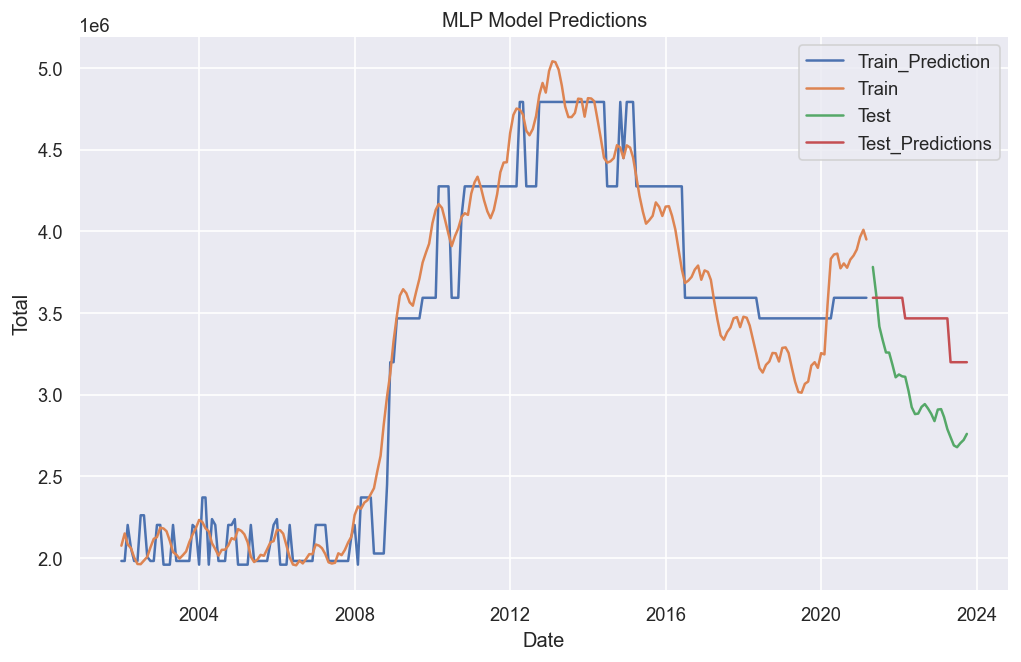

In [239]:
# Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

# In-sample predictions
predictions_train = MLP_fit.predict(X_train2)
dfTR_eval['MLP_pred'] = predictions_train

# Out-of-sample predictions
predictions_test = MLP_fit.predict(X_test2)
dfTS_eval['MLP_pred'] = predictions_test

# Visualize the results
plt.figure(figsize=(10, 6))


# Plotting in-sample predictions
plt.plot(y_train2.index, dfTR_eval['MLP_pred'], label='Train_Prediction')

# Plotting in-sample predictions
plt.plot(y_train2.index, y_train2, label='Train')

# Plotting out-of-sample predictions
plt.plot(y_test2.index, y_test2, label='Test')

# Plotting actual values
plt.plot(y_test2.index, dfTS_eval['MLP_pred'], label='Test_Predictions')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('MLP Model Predictions')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_pred'])

# MLP 2

Ahora entrenamos un modelo MLP, dentro de las variables metemos COVID, Lag1 y Lag2

In [240]:
df['TOTAL'] = df['TOTAL']/1000000

In [241]:
# Extract year and month
df['COVID'] = df.COVID.astype('category')

In [242]:
###Includb
dfT = df[['TOTAL','COVID']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
#dfT['TOTAL_lag12'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL COVID  TOTAL_lag1  TOTAL_lag2
DATE                                              
2001-01-01  2.017389     0         NaN         NaN
2001-02-01  1.993273     0    2.017389         NaN
2001-03-01  1.981006     0    1.993273    2.017389
2001-04-01  1.910453     0    1.981006    1.993273
2001-05-01  1.898285     0    1.910453    1.981006

In [243]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL COVID  TOTAL_lag1  TOTAL_lag2
DATE                                              
2001-03-01  1.981006     0    1.993273    2.017389
2001-04-01  1.910453     0    1.981006    1.993273
2001-05-01  1.898285     0    1.910453    1.981006
2001-06-01  1.842556     0    1.898285    1.910453
2001-07-01  1.835738     0    1.842556    1.898285

In [276]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag2','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2.head()

TOTAL_lag1  TOTAL_lag2 COVID
DATE                                    
2001-03-01    1.993273    2.017389     0
2001-04-01    1.981006    1.993273     0
2001-05-01    1.910453    1.981006     0
2001-06-01    1.898285    1.910453     0
2001-07-01    1.842556    1.898285     0

In [245]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag2']
INPUTS_MLP_CAT = ['COVID'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.00001,0.0001,0.01,0.1,1], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(10,),(20,),(25,),(30,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train2[INPUTS_MLP], y_train2) # Search in grid
print("MLP Trained")

MLP Trained


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

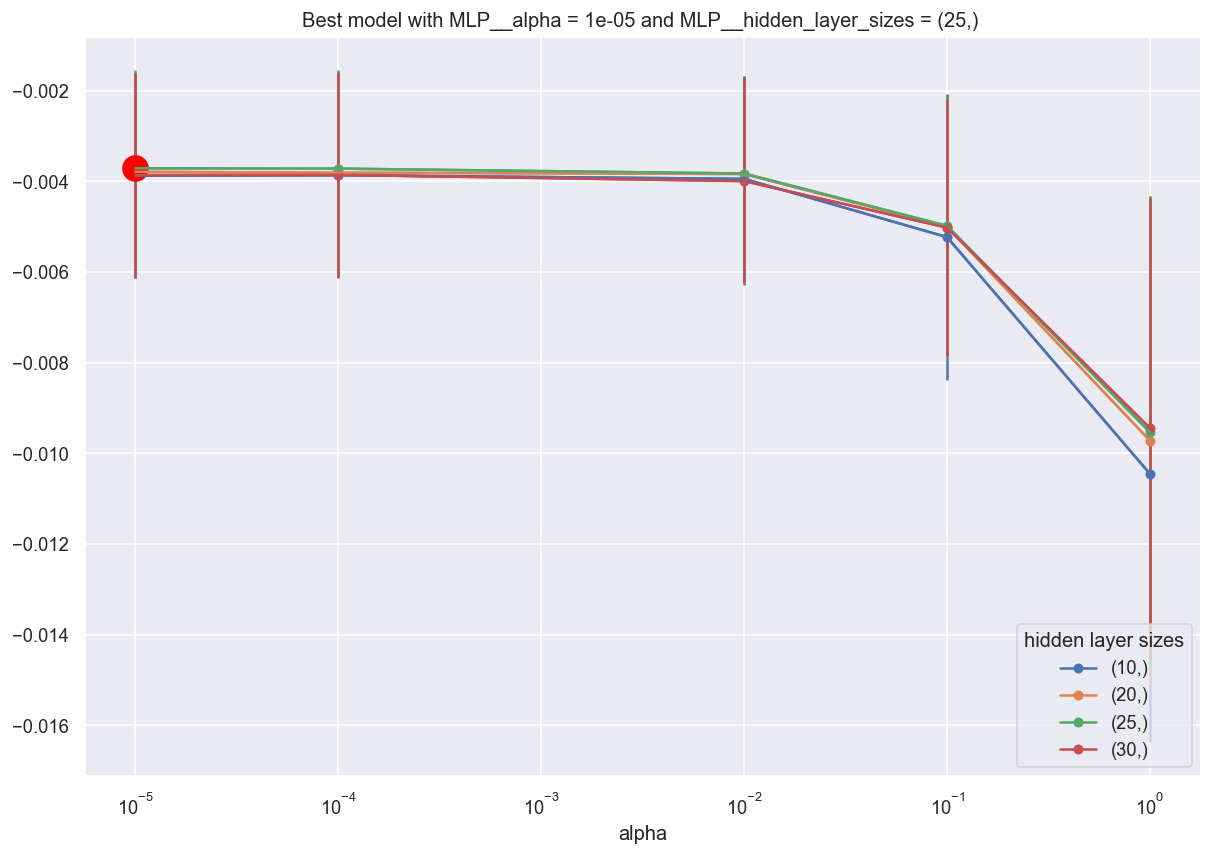

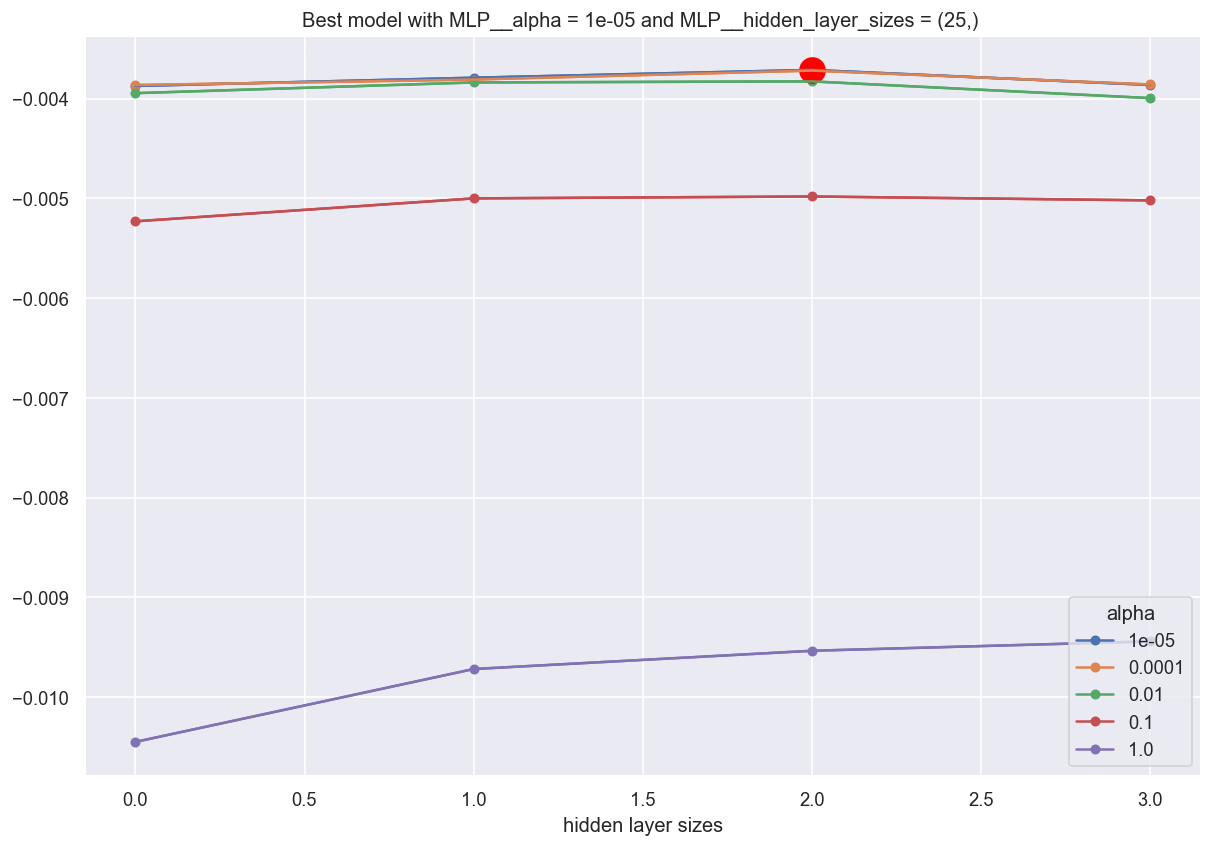

In [246]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [247]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train2) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)

#X = pd.DataFrame(X.toarray(), columns=coefnames)
y = pd.DataFrame(y_train2, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [3, 25, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                     mean       std  mean_squared
num__TOTAL_lag1  1.552493  0.046466      1.553188
num__TOTAL_lag2 -0.561456  0.012251      0.561590
cat__COVID_1     0.025596  0.004116      0.025924


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\neuralsens\partial_derivatives.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(sens_out["mean"][i], sens_out["std"][i]),
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


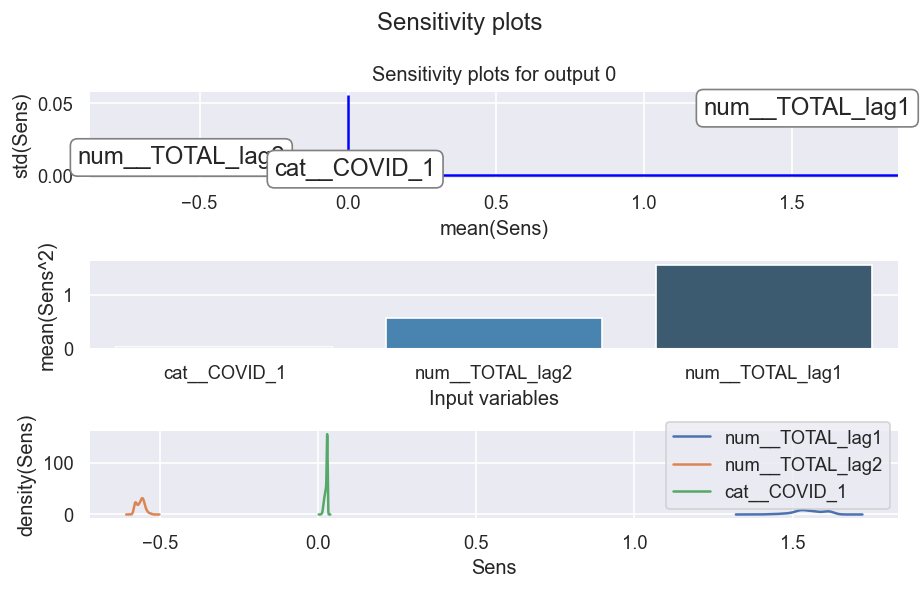

In [248]:
sensmlp.plot()

In [249]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train2)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test2)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))

#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 0.04510198275613505
Test MAE: 0.046934208056439095
Training RMSE: 0.058054409445787505
Test RMSE: 0.06073141878991002
Training R2: 0.9967569467432899
Test R2: 0.9684630708373775


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

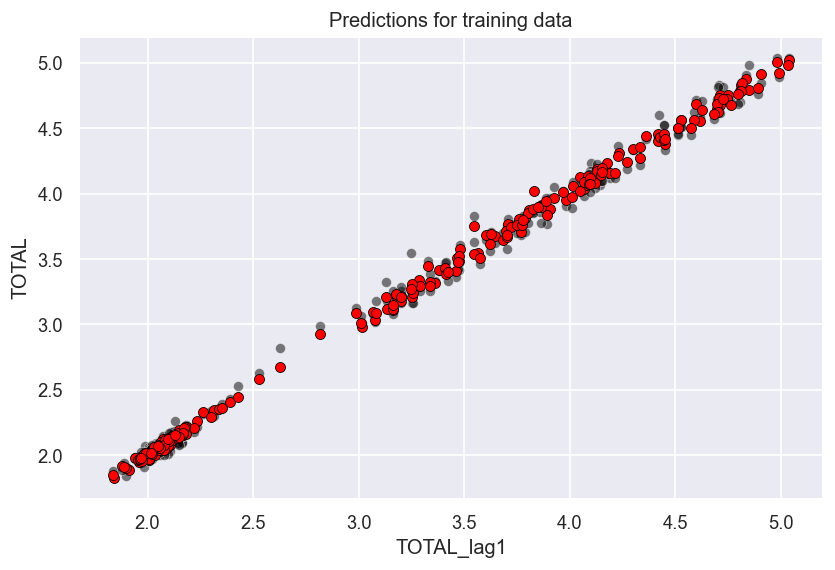

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

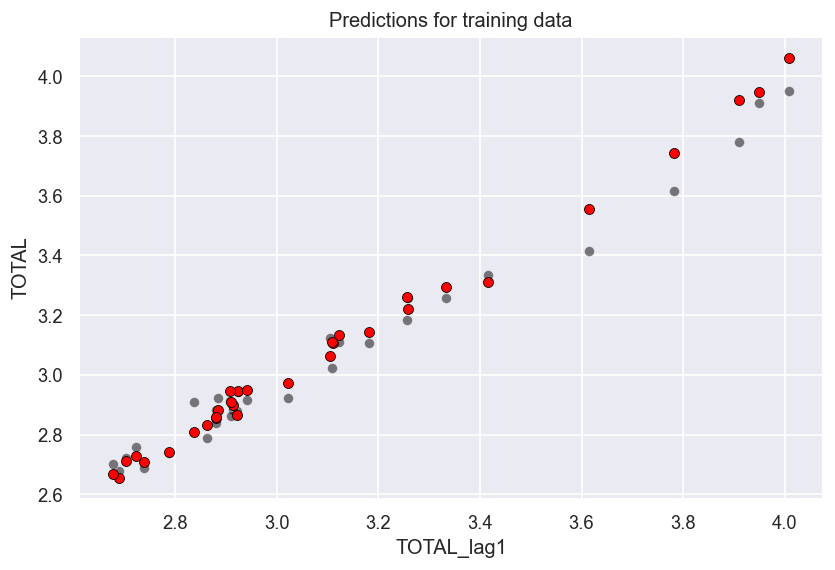

In [250]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


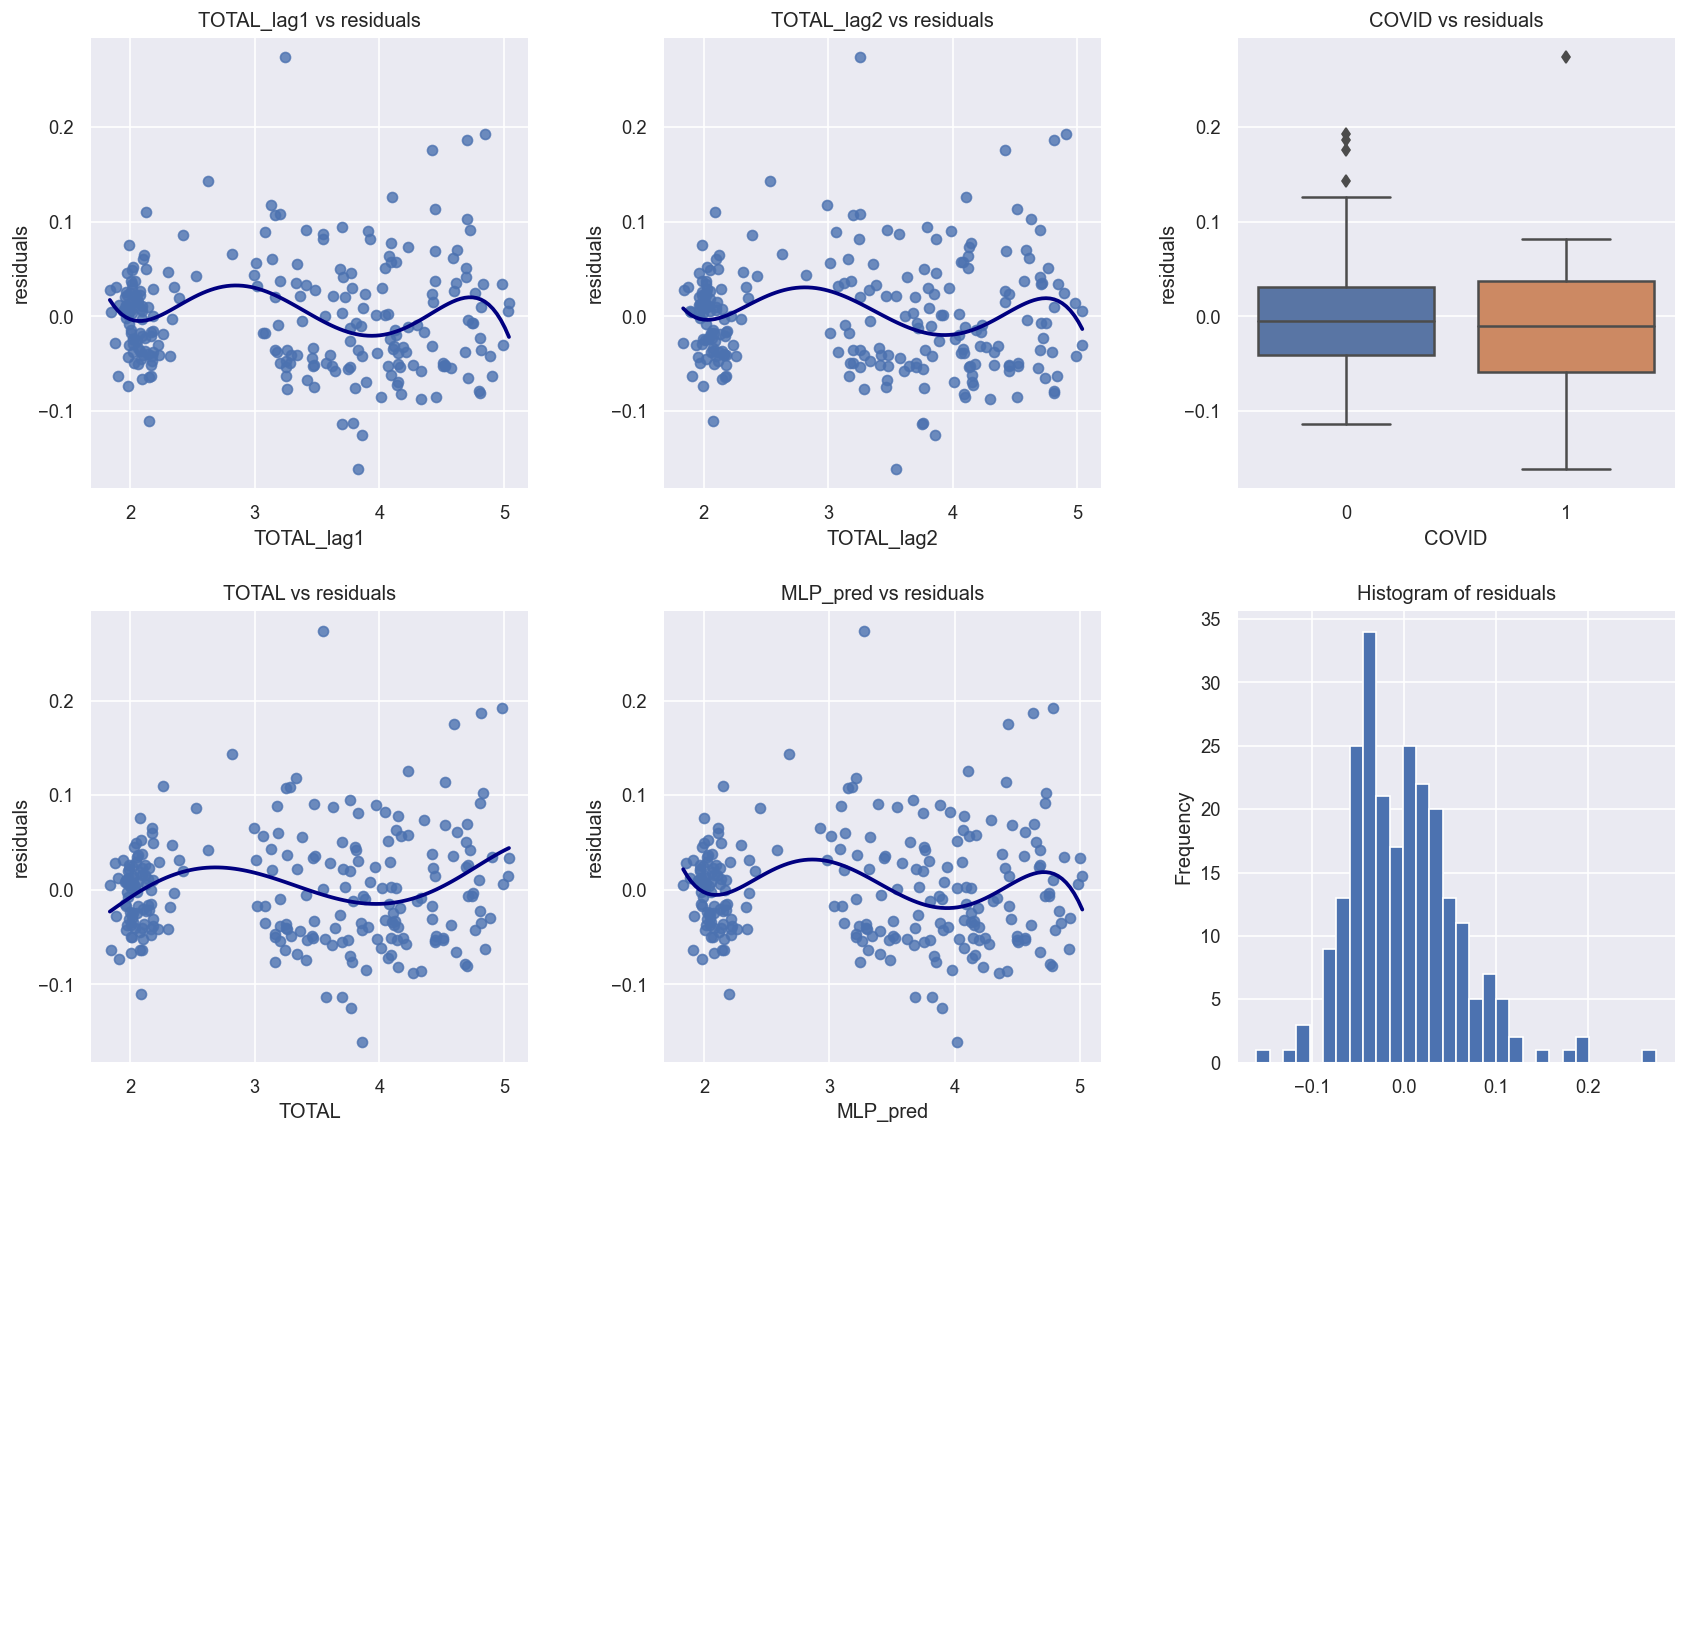

In [251]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

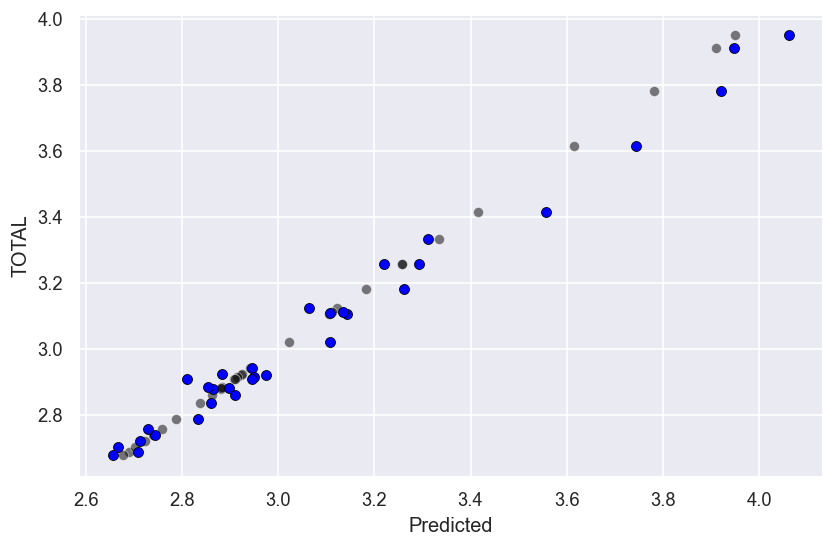

In [252]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

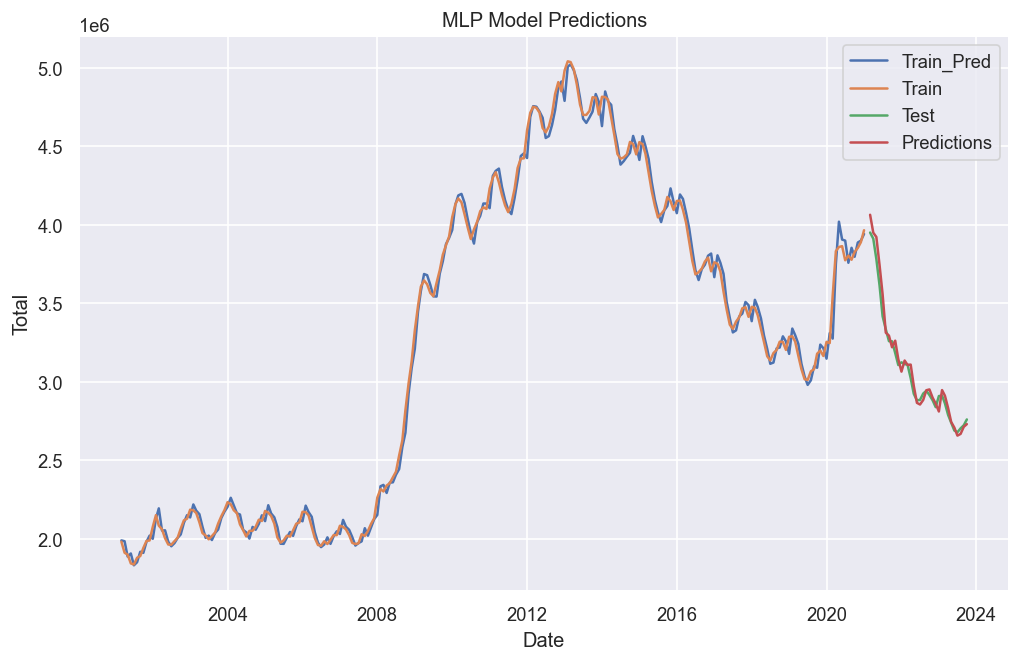

In [253]:
# Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

# In-sample predictions
predictions_train = MLP_fit.predict(X_train2)
dfTR_eval['MLP_pred'] = predictions_train*1000000

# Out-of-sample predictions
predictions_test = MLP_fit.predict(X_test2)
dfTS_eval['MLP_pred'] = predictions_test*1000000

# Visualize the results
plt.figure(figsize=(10, 6))

# Plotting in-sample predictions
plt.plot(y_train2.index, dfTR_eval['MLP_pred'], label='Train_Pred')

plt.plot(y_train2.index, y_train2*1000000, label='Train')

# Plotting out-of-sample predictions
plt.plot(y_test2.index, y_test2*1000000, label='Test')

# Plotting actual values
plt.plot(y_test2.index, dfTS_eval['MLP_pred'], label='Predictions')

# Filling confidence interval if available
#if 'yhat_conf_int' in locals():
 #   plt.fill_between(yhat_conf_int.index, yhat_conf_int.iloc[:, 0], yhat_conf_int.iloc[:, 1], color='k', alpha=.2)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('MLP Model Predictions')
plt.legend()

# Show the plot
plt.show()

In [279]:
 X_test2.index

DatetimeIndex(['2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [285]:
#Predicción Noviembre MLP
noviembre_2023 = {'TOTAL_lag1':y_test2.loc[pd.to_datetime('2023-10-01')],'TOTAL_lag2':X_test2.loc[pd.to_datetime('2023-10-01')]['TOTAL_lag1'],'COVID': 0.0}
#diciembre_2023 = {'COVID': 0.0}

# Añadir la nueva observación usando loc
X_test2.loc[pd.to_datetime('2023-11-01')] = noviembre_2023
#X_test2.loc[pd.to_datetime('2023-12-01')] = diciembre_2023#No me deja sin meter la de diciembre tb.

predictions_test = MLP_fit.predict(X_test2)

predictions_test=predictions_test*1000000

predictions_test = pd.Series(predictions_test, index=X_test2.index)
predictions_test


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

DATE
2021-03-01    4.062874e+06
2021-04-01    3.948596e+06
2021-05-01    3.921218e+06
2021-06-01    3.743731e+06
2021-07-01    3.556529e+06
2021-08-01    3.312331e+06
2021-09-01    3.293184e+06
2021-10-01    3.219244e+06
2021-11-01    3.261115e+06
2021-12-01    3.143642e+06
2022-01-01    3.064047e+06
2022-02-01    3.134630e+06
2022-03-01    3.106860e+06
2022-04-01    3.108674e+06
2022-05-01    2.973820e+06
2022-06-01    2.865184e+06
2022-07-01    2.854450e+06
2022-08-01    2.883374e+06
2022-09-01    2.945395e+06
2022-10-01    2.950509e+06
2022-11-01    2.897856e+06
2022-12-01    2.860219e+06
2023-01-01    2.810194e+06
2023-02-01    2.946431e+06
2023-03-01    2.910628e+06
2023-04-01    2.832277e+06
2023-05-01    2.743472e+06
2023-06-01    2.707591e+06
2023-07-01    2.656447e+06
2023-08-01    2.667406e+06
2023-09-01    2.712449e+06
2023-10-01    2.729525e+06
2023-11-01    2.776440e+06
dtype: float64

# Linear Regression

In [ ]:
df['TOTAL'] = df['TOTAL']*1000000

In [ ]:
# Define input and output matrices
prop_train=0.88
dfT=df.copy()
dfT['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 dura
dfT.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1

dfT['TOTAL_lag1'] = dfT['TOTAL'].shift(1)
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag12'] = dfT['TOTAL'].shift(12)
dfT['COVID'].astype('category')

# Remove missing
dfT.dropna(inplace=True)
dfT.head()
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag12','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2

In [ ]:
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Assuming you already have X_train2 and y_train2

# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR_NUM = ['TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag12']
INPUTS_LR_CAT = ["COVID"]
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories DROPPING FIRST CATEGORY (DUMMY ENCODE)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_LR_NUM),
    ('cat', categorical_transformer, INPUTS_LR_CAT)
])

# Combine preprocessing and linear regression into a pipeline
pipe = Pipeline(steps=[
    ('Prep', preprocessor),  # Preprocess the variables when training the model
])

# Split the data into training and testing sets
 
# Apply the preprocessor to X_train
X_train_processed = preprocessor.fit_transform(X_train2)

# Add a constant for intercept term
X_train_processed = sm.add_constant(X_train2)

# Train the linear regression model with Statsmodels
model = sm.OLS(y_train2, X_train_processed).fit()

# Print the summary, including p-values
print(model.summary())


In [ ]:

print(X_train2)

# Add a constant for intercept term
X_train2_pred = sm.add_constant(X_train2)

# Make predictions
predictions_train = model.predict(X_train2_pred)

# Add a constant for intercept term
X_test2_pred = sm.add_constant(X_test2)

# Make predictions
predictions_test = model.predict(X_test2_pred)


# Print predictions
print("Predictions:", predictions_test)

dfTR_eval['LR_pred'] = predictions_train
dfTS_eval['LR_pred'] = predictions_test

In [335]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['LR_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['LR_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['LR_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['LR_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['LR_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['LR_pred']))

Training MAE: 45908.65299798228
Test MAE: 43447.33295904609
Training RMSE: 58930.95069622364
Test RMSE: 55536.90079785549
Training R2: 0.9965219219280481
Test R2: 0.9569629446091574


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


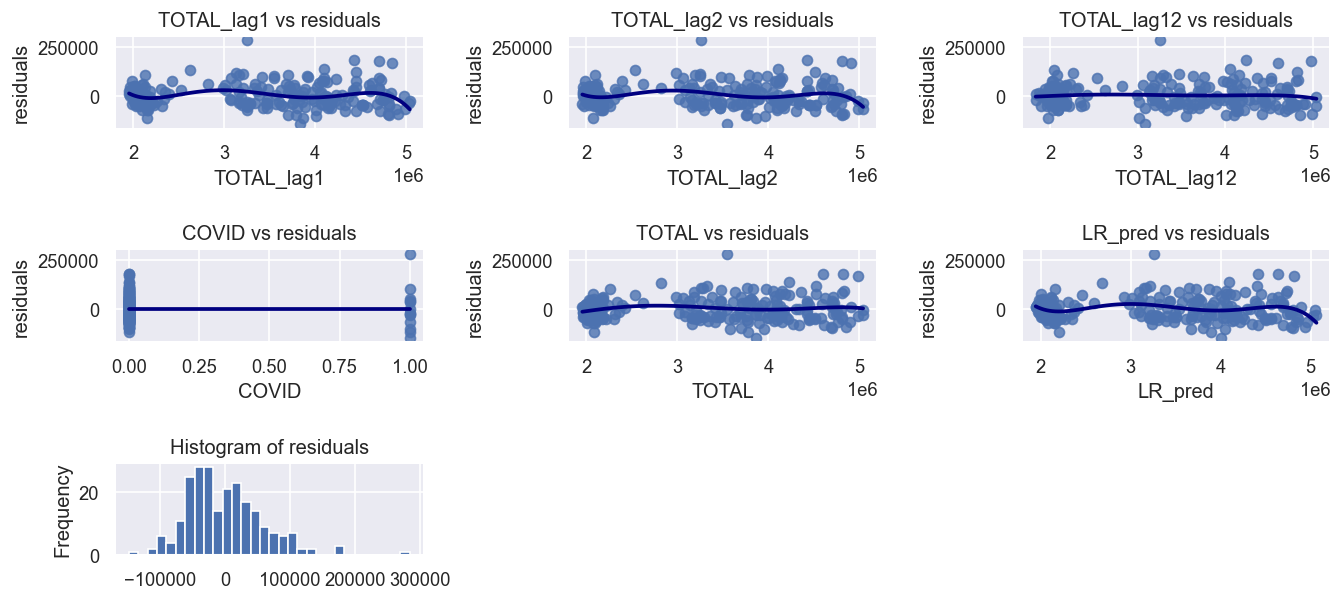

In [336]:
RT.plotModelDiagnosis(dfTR_eval, 'LR_pred', 'TOTAL') 

In [337]:
from scipy.stats import spearmanr

correlation, p_value = spearmanr(dfT['TOTAL_lag1'],dfT['TOTAL_lag2'] )

correlation

0.993065348729287

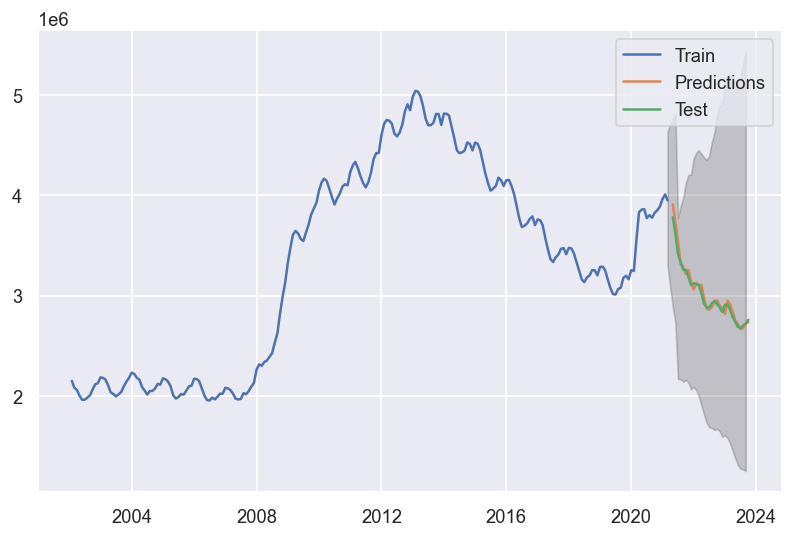

In [338]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

yhat = predictions_test

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

# EXTRA: PROPHET

In [472]:
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t')

In [473]:
y2 = df.copy()
y3 = y2.copy()
y4 = y2.copy()
y_train2 = y2.iloc[0:round(prop_train*y2.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y2.iloc[round(prop_train*y2.shape[0])+1:round(y2.shape[0])]
y2 = y2.set_index('DATE')

In [474]:
y_train2 = y_train2.rename(columns={'DATE': 'ds',
                        'TOTAL': 'y'})
y_train2.head()

ds        y
0 2001-01-01  2017389
1 2001-02-01  1993273
2 2001-03-01  1981006
3 2001-04-01  1910453
4 2001-05-01  1898285

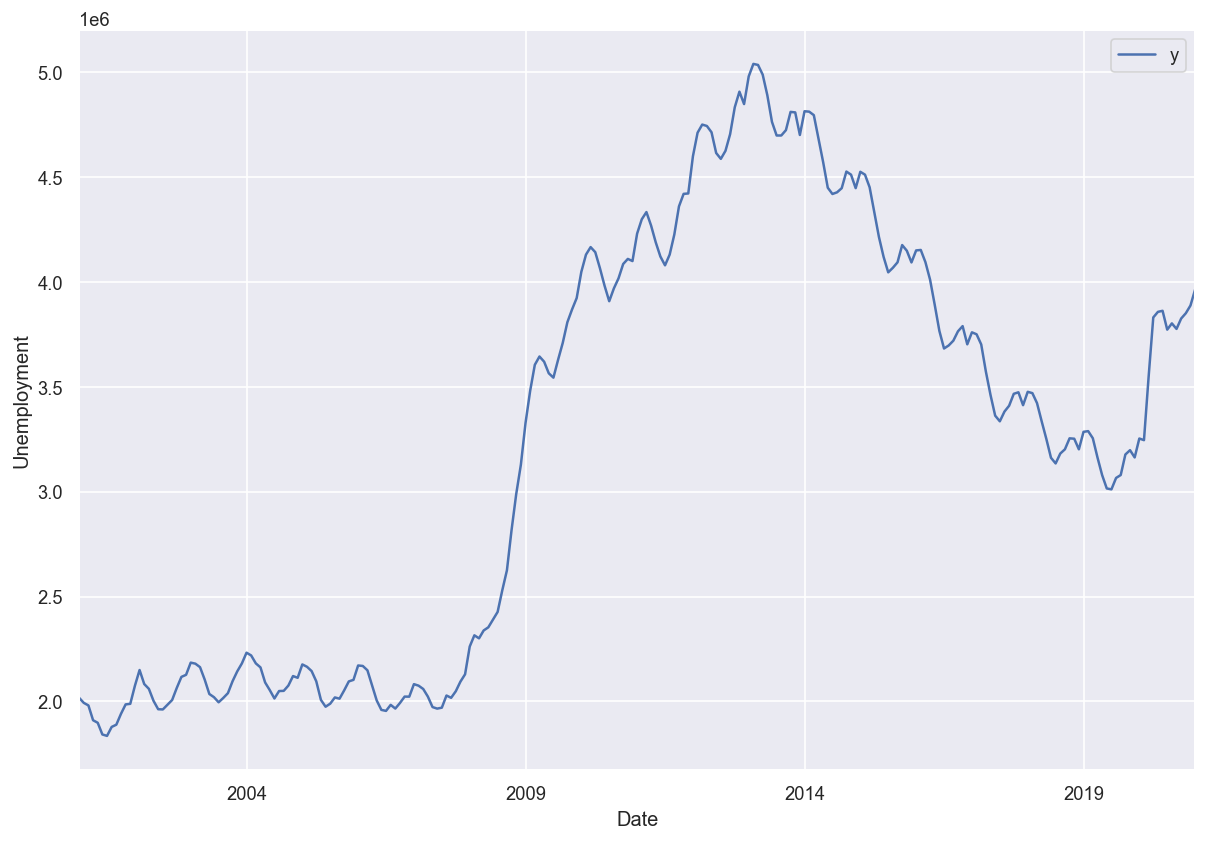

In [475]:
ax = y_train2.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Unemployment')
ax.set_xlabel('Date')

plt.show()

In [476]:
prophet_fit = Prophet()
prophet_fit.fit(y_train2)

16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing


In [477]:
n_years = 3
future_dates = prophet_fit.make_future_dataframe(periods=n_years*12, freq='MS')
future_dates.head()

ds
0 2001-01-01
1 2001-02-01
2 2001-03-01
3 2001-04-01
4 2001-05-01

In [478]:
future = prophet_fit.predict(future_dates)
future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds          yhat    yhat_lower    yhat_upper
0 2001-01-01  2.127094e+06  1.893930e+06  2.364401e+06
1 2001-02-01  2.074475e+06  1.831924e+06  2.316860e+06
2 2001-03-01  2.060166e+06  1.833850e+06  2.293445e+06
3 2001-04-01  2.044249e+06  1.804753e+06  2.290564e+06
4 2001-05-01  1.980027e+06  1.712943e+06  2.229689e+06

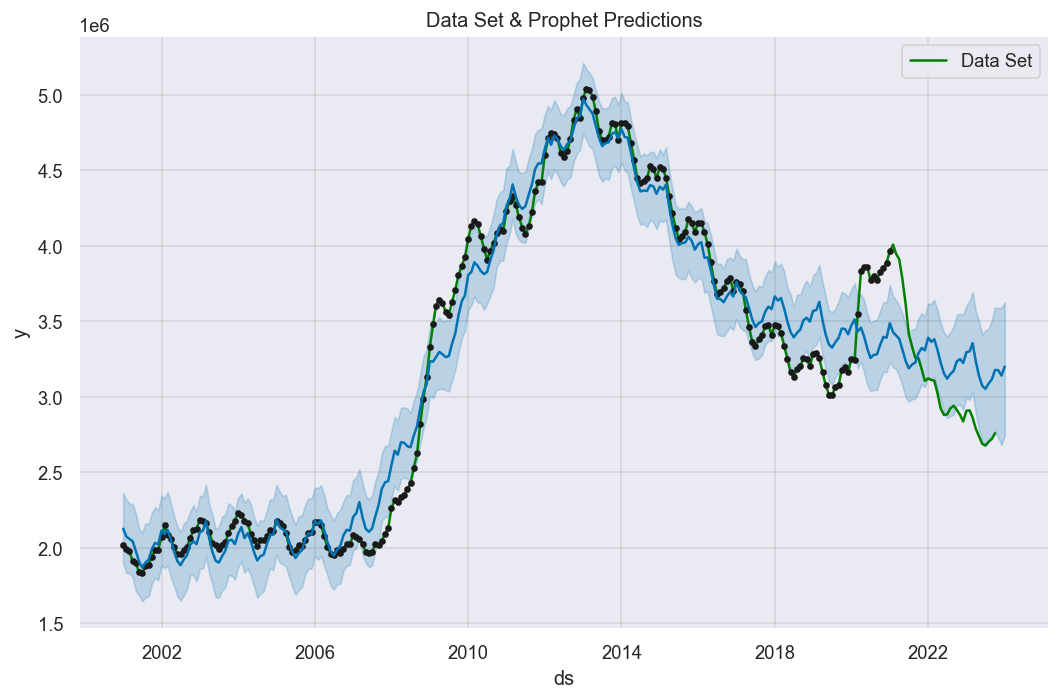

In [479]:
# Crear un nuevo gráfico para tu conjunto de datos y Prophet
plt.figure(figsize=(9, 6))  # Ajusta el tamaño según tus necesidades

# Agregar el gráfico de tu conjunto de datos
plt.plot(y2, label='Data Set', color='green')

# Agregar detalles al gráfico (etiquetas, leyenda, etc.)
plt.title('Data Set & Prophet Predictions')
plt.legend()

# Agregar el gráfico de Prophet (supongo que prophet_fit es tu modelo Prophet)
prophet_fit.plot(future, uncertainty=True, ax=plt.gca())  # Utiliza el mismo eje (ax) para combinarlos

# Mostrar el gráfico combinado
plt.show()

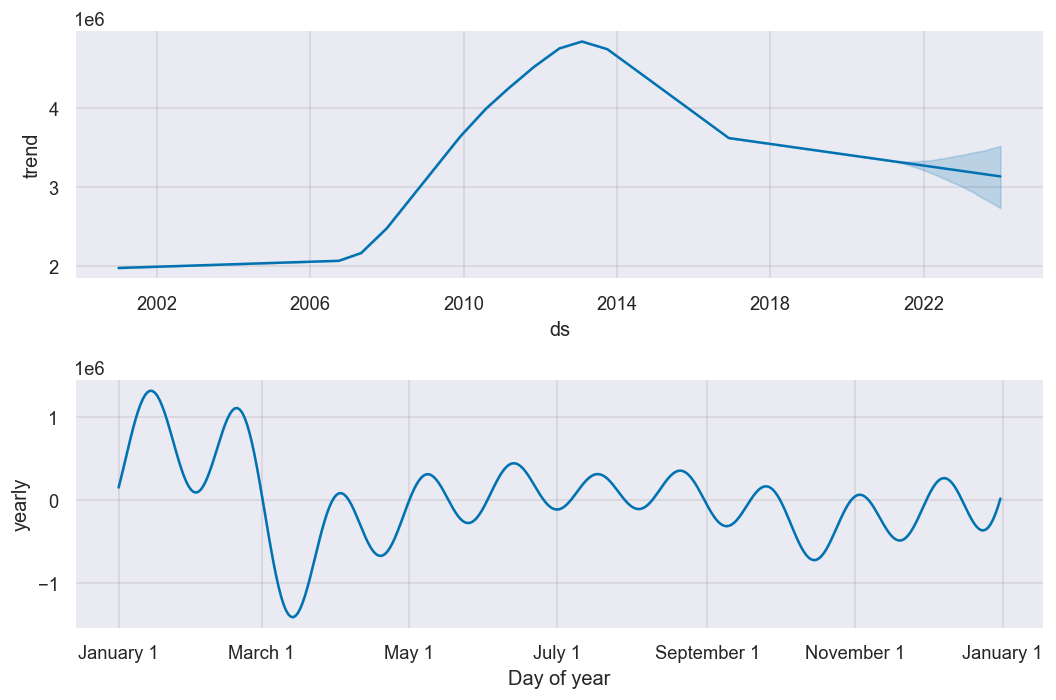

In [480]:
fig = prophet_fit.plot_components(future)

#### Plot changepoints

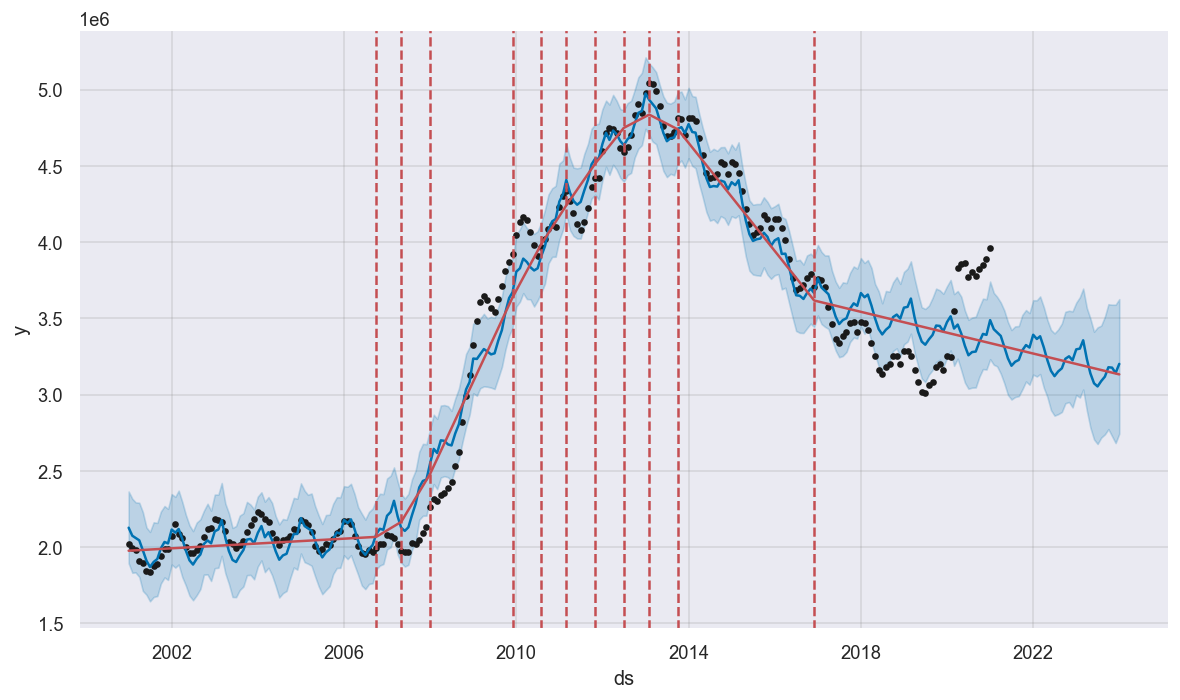

In [481]:
fig = prophet_fit.plot(future)
a = add_changepoints_to_plot(fig.gca(), prophet_fit, future)

#### Adjusting trend flexibility

16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1080x720 with 0 Axes>

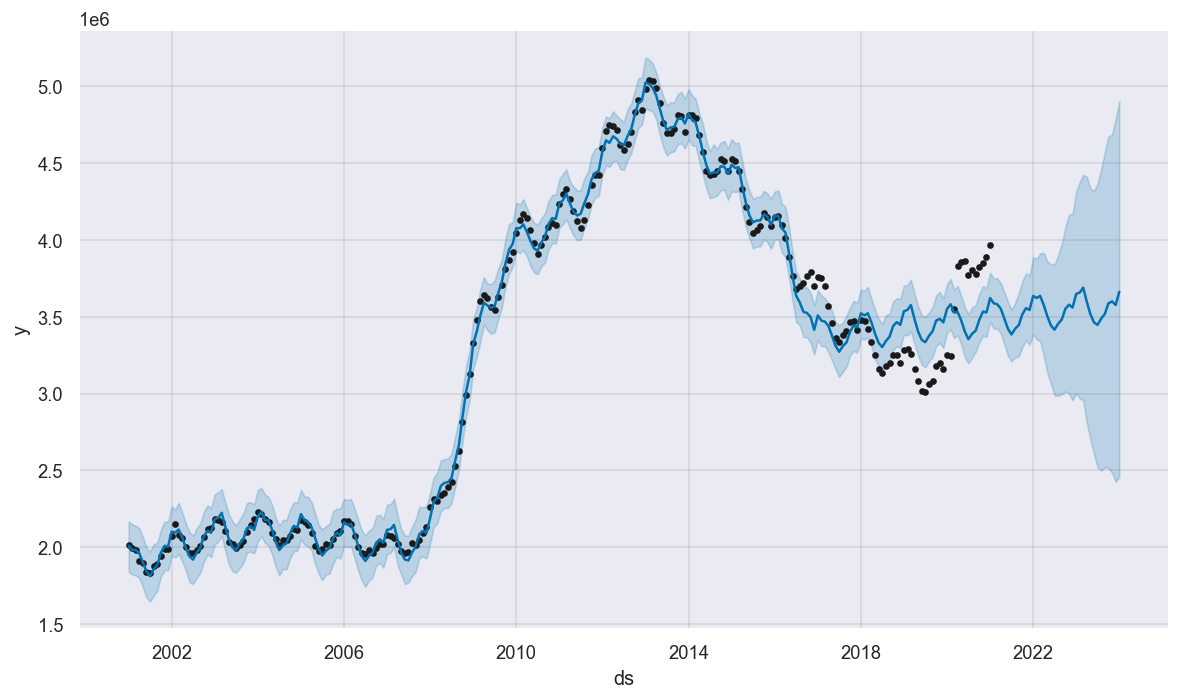

In [482]:
plt.figure(figsize=(9, 6))  # Ajusta el tamaño según tus necesidades
prophet_trend_fit = Prophet(changepoint_prior_scale=2)
future = prophet_trend_fit.fit(y_train2).predict(future)
fig = prophet_trend_fit.plot(future)

16:45:45 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing
16:45:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:45:45 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1080x720 with 0 Axes>

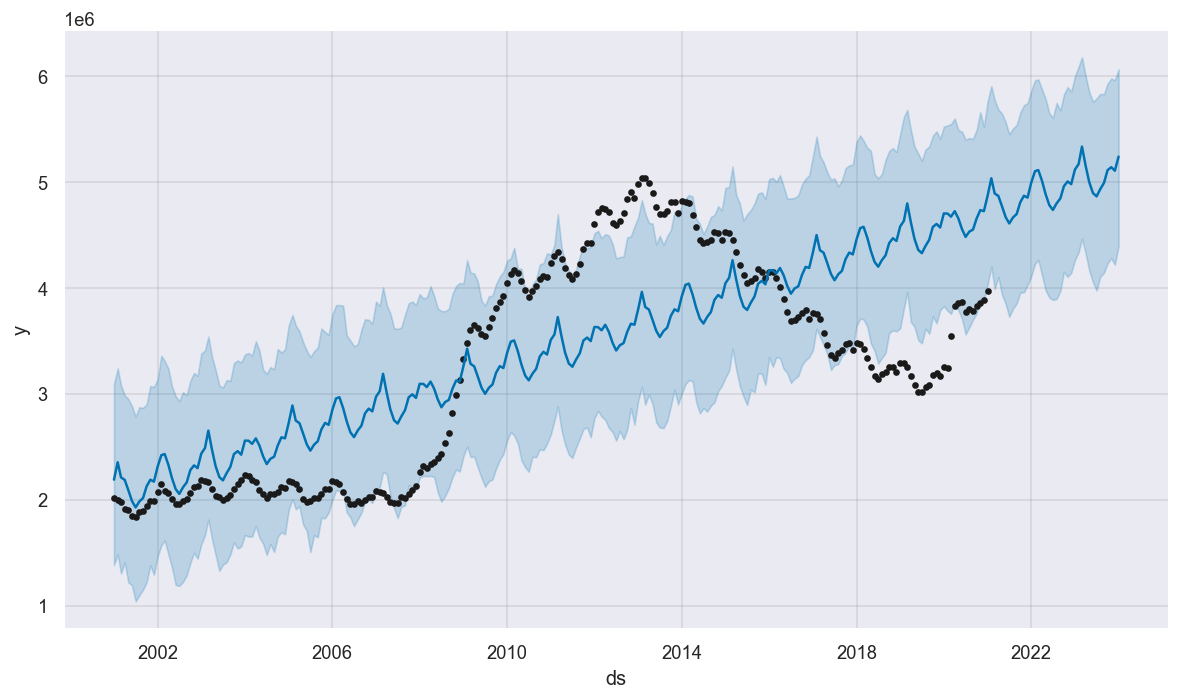

In [483]:
plt.figure(figsize=(9, 6))  # Ajusta el tamaño según tus necesidades
prophet_trend_fit = Prophet(changepoint_prior_scale=0.0001)
future = prophet_trend_fit.fit(y_train2).predict(future)
fig = prophet_trend_fit.plot(future)

CHanging the changepoints does not help (proven).

### Modelling holidays and special events

In [484]:
y3['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-03-01') #Parece que aquí termina su influencia ascendente en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
y3.loc[(y3['DATE'] > periodo_covid_inicio) & (y3['DATE'] < periodo_covid_fin_1), 'COVID'] = 1

In [485]:
covid = y3[['DATE', 'COVID']].copy()
covid['COVID'] = covid['COVID'].replace({0: 'NOCOVID', 1: 'COVID'})

In [486]:
covid = covid.rename(columns={'DATE': 'ds',
                        'COVID': 'holiday'})
covid.head()

covid['ds'] = pd.to_datetime(covid['ds'])

In [487]:
prophet_hol = Prophet(holidays=covid)
prophet_hol.fit(y_train2)

16:45:53 - cmdstanpy - INFO - Chain [1] start processing


16:45:53 - cmdstanpy - INFO - Chain [1] done processing


In [488]:
future = prophet_hol.make_future_dataframe(periods=n_years*12, freq='MS')
forecast = prophet_hol.predict(future)

<Figure size 1080x720 with 0 Axes>

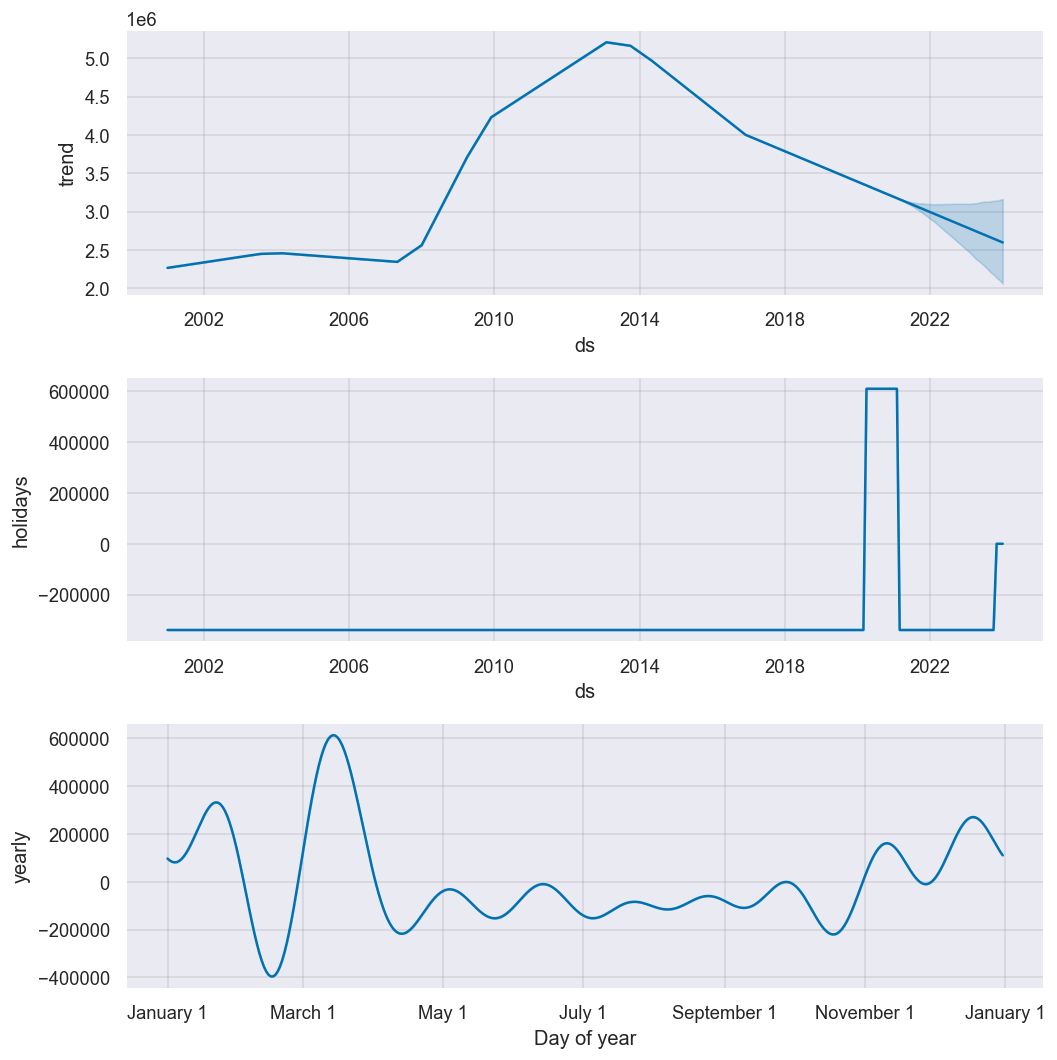

In [489]:
plt.figure(figsize=(9, 6))  # Ajusta el tamaño según tus necesidades
fig = prophet_hol.plot_components(forecast)

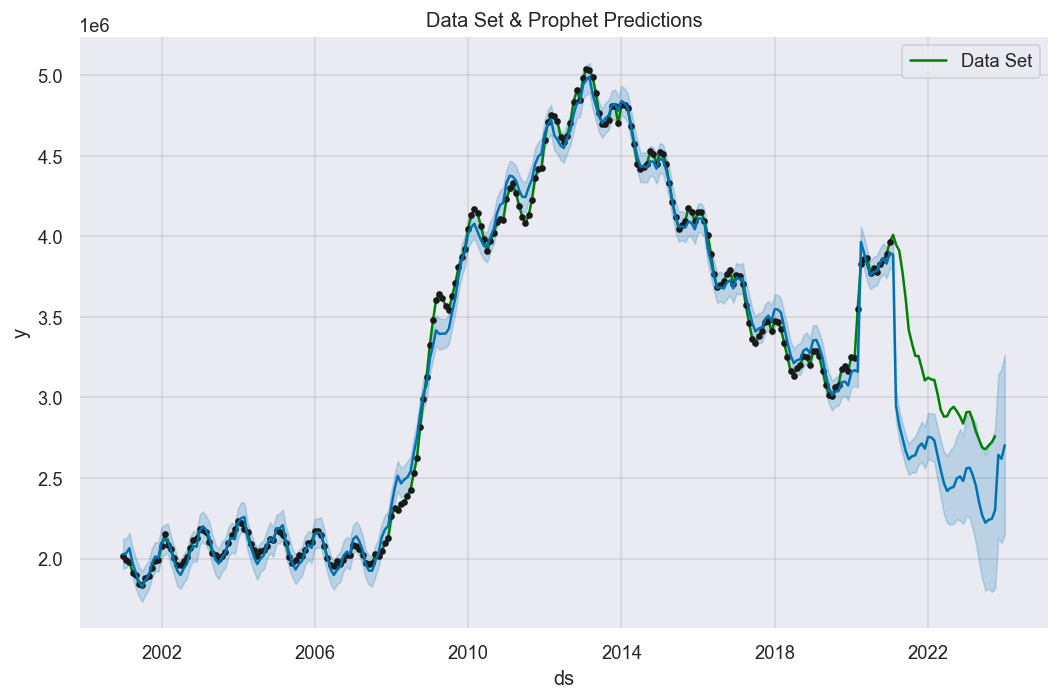

In [490]:
# Crear un nuevo gráfico para tu conjunto de datos y Prophet
plt.figure(figsize=(9, 6))  # Ajusta el tamaño según tus necesidades

# Agregar el gráfico de tu conjunto de datos
plt.plot(y2, label='Data Set', color='green')

# Agregar detalles al gráfico (etiquetas, leyenda, etc.)
plt.title('Data Set & Prophet Predictions')
plt.legend()

# Agregar el gráfico de Prophet (supongo que prophet_fit es tu modelo Prophet)
prophet_fit.plot(forecast, uncertainty=True, ax=plt.gca())  # Utiliza el mismo eje (ax) para combinarlos

# Mostrar el gráfico combinado
plt.show()

In [491]:
prophet_trend_fit = Prophet(changepoint_prior_scale=2, holidays=covid)
prophet_hol = prophet_trend_fit.fit(y_train2)
future = prophet_hol.make_future_dataframe(periods=n_years*12, freq='MS')
forecast = prophet_hol.predict(future)

16:45:56 - cmdstanpy - INFO - Chain [1] start processing
16:45:56 - cmdstanpy - INFO - Chain [1] done processing


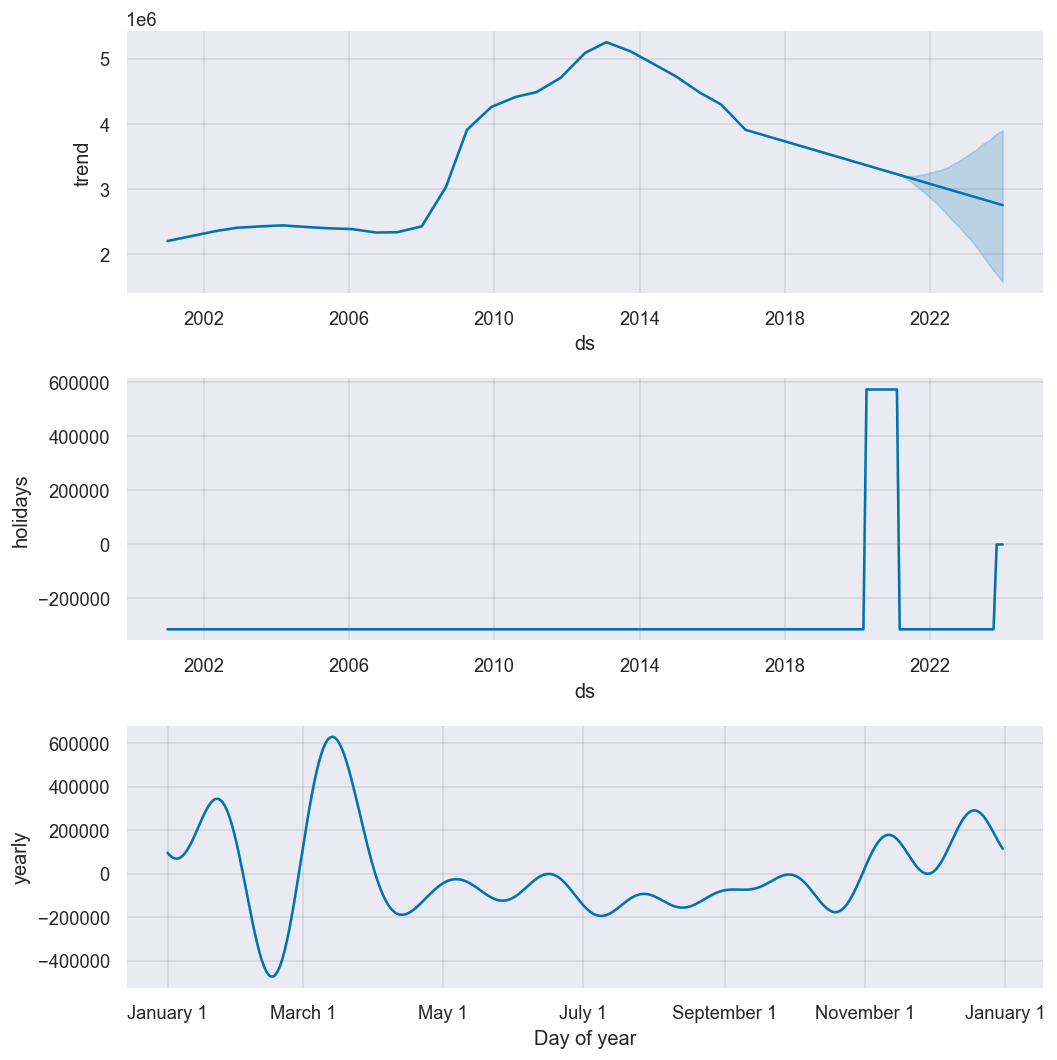

In [492]:
fig = prophet_hol.plot_components(forecast)

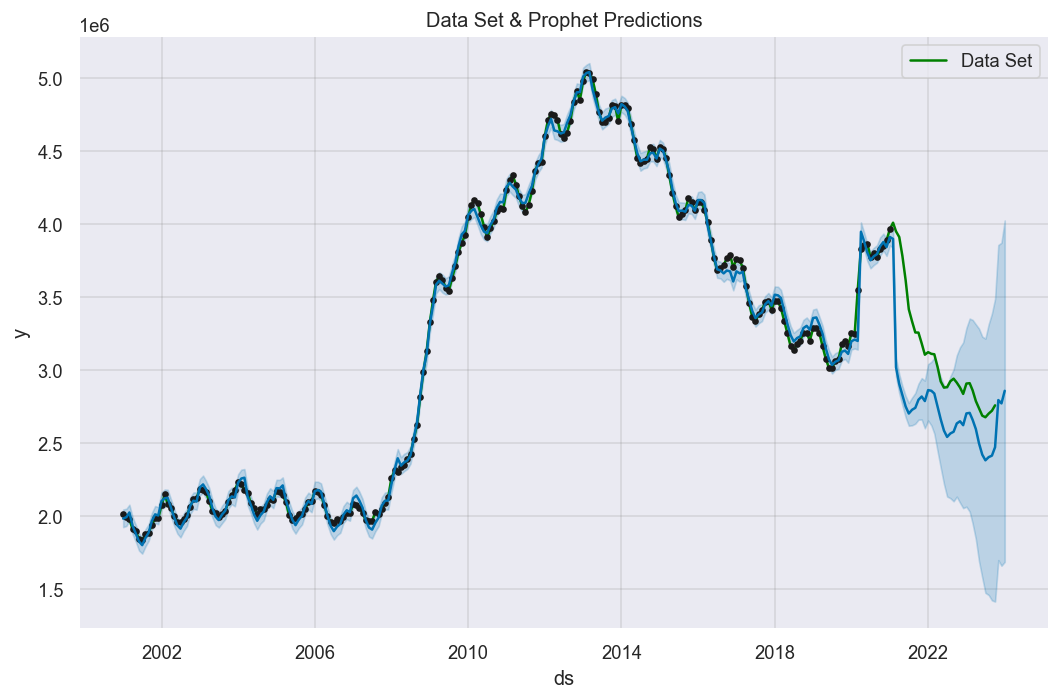

In [495]:
# Crear un nuevo gráfico para tu conjunto de datos y Prophet
plt.figure(figsize=(9, 6))  # Ajusta el tamaño según tus necesidades

# Agregar el gráfico de tu conjunto de datos
plt.plot(y2, label='Data Set', color='green')

# Agregar detalles al gráfico (etiquetas, leyenda, etc.)
plt.title('Data Set & Prophet Predictions')
plt.legend()

# Agregar el gráfico de Prophet (supongo que prophet_fit es tu modelo Prophet)
prophet_fit.plot(forecast, uncertainty=True, ax=plt.gca())  # Utiliza el mismo eje (ax) para combinarlos

# Mostrar el gráfico combinado
plt.show()